In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from utils import (Expando, _calculate_S_star_BL_G,_calculate_S_star_BL_L, calculate_cvar_left, _left_tail_weighted_sum, _left_tail_mask,compute_cvar_derivative_mixed,weighted_expected_value  )
import gurobipy as gp
from gurobipy import GRB
import copy
from scipy.optimize import minimize_scalar, brentq
from scipy import stats
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any, Optional
%matplotlib inline


In [2]:
# Load Scenario Data
num_scenarios = 500
time_horizon = 20 #  5,10,20
discount_rate_G = 0.00 # %
discount_rate_L = 0.00 # %
alpha = 0.95  # Weighting factor for strike price calculation
contract_type = 'Baseload'  # Baseload ,PAP

#Discount Array 
discount_factors_G = 1 / (1 + discount_rate_G) ** np.arange(time_horizon)
discount_factors_G = discount_factors_G[:, None]

discount_factors_L = 1 / (1 + discount_rate_L) ** np.arange(time_horizon)
discount_factors_L = discount_factors_L[:, None]


scenario_pattern_reduced = f"{{type}}_scenarios_reduced_{time_horizon}y_{num_scenarios}s.csv"

# Load price scenarios
prices_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='price')}", index_col=0) # Mio EUR/GWh
prices_df.index = pd.to_datetime(prices_df.index)   
prices = prices_df.values
prices_mwh = prices_df * 1000  # Convert from EUR/GWh to EUR/MWh

#prices_mwh = prices_mwh + 0.01*prices_mwh.mean().mean()

# Load production scenarios
prod_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='production')}", index_col=0) # GWh
prod_df.index = pd.to_datetime(prod_df.index)
prod = prod_df.values
# Load capture rate scenarios
CR_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='capture_rate')}", index_col=0)
CR_df.index = pd.to_datetime(CR_df.index)    # Load load scenarios
CR = CR_df.values
load_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='load')}", index_col=0) # GWh
load_df.index = pd.to_datetime(load_df.index)
load = load_df.values

LR_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='load_capture_rate')}", index_col=0) # %
LR_df.index = pd.to_datetime(LR_df.index)
LR = LR_df.values

probability_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='probabilities')}", index_col=0) # 
PROB = probability_df.values.flatten()  # Probability array

In [3]:
class NashBargaining:
    def __init__(self, input_data,fixed_contract_amount=None):
        """Initialize contract negotiation model with loaded scenarios.
        
        Args:
            input_data: Input data object containing loaded scenarios and parameters
        """        
        self.data = input_data
        self.results = Expando()
        self.variables = Expando()
        self.constraints = Expando()
        self.fixed_contract_amount = fixed_contract_amount  # Fixed M value

        
        self._build_model()

    def _get_S(self, s=None):
        """Helper method to access strike price variable S.
        
        Args:
            s: Scenario index (optional, required if S is scenario-indexed)
            
        Returns:
            Gurobi variable (S[s] if indexed, S if scalar)
        """
        if self.data.Scenarios_S:
            if s is None:
                raise ValueError("Scenario index required when S is scenario-indexed")
            return self.variables.S[s]
        else:
            return self.variables.S

    def _get_M(self, s=None):
        """Helper method to access contract amount variable M.
        
        Args:
            s: Scenario index (optional, required if M is scenario-indexed)
            
        Returns:
            Gurobi variable (M[s] if indexed, M if scalar)
        """
        if self.data.Scenarios_M:
            if s is None:
                raise ValueError("Scenario index required when M is scenario-indexed")
            return self.variables.M[s]
        else:
            return self.variables.M

    def _build_variables(self):
        """Build optimization variables for contract negotiation."""
        EPS = 1e-8  # Small positive number for numerical stability
        
        # Define log-based auxiliary variables
        for name in ['arg_G', 'arg_L', 'log_arg_G', 'log_arg_L']:
              setattr(self.variables, name, self.model.addVar(lb=EPS, name=name))

        # Define core optimization variables (per scenario or scalar)
        if self.data.Scenarios_S:
            setattr(self.variables, 'S', self.model.addVars(self.data.SCENARIOS, lb=self.data.strikeprice_min, ub=self.data.strikeprice_max, name='Strike_Price'))
        else: 
            setattr(self.variables, 'S', self.model.addVar(lb=self.data.strikeprice_min, ub=self.data.strikeprice_max, name='Strike_Price'))

        if self.data.Scenarios_M:
            setattr(self.variables, 'M', self.model.addVars(self.data.SCENARIOS, lb=self.data.contract_amount_min, ub=self.data.contract_amount_max, name='Contract_Amount'))
        else:
            setattr(self.variables, 'M', self.model.addVar(lb=self.data.contract_amount_min, ub=self.data.contract_amount_max, name='Contract_Amount'))

        # Define auxiliary variables for optimization
        for name in ['zeta_G', 'zeta_L']:
            setattr(self.variables, name, self.model.addVar(name=f'Zeta_Auxillary_{name[-1]}', lb=-gp.GRB.INFINITY, ub=gp.GRB.INFINITY))

        # Define scenario-based eta variables
        for name in ['eta_G', 'eta_L']:
            setattr(self.variables, name, self.model.addVars(self.data.SCENARIOS, name=f'Auxillary_Variable_{name[-1]}', lb=0, ub=gp.GRB.INFINITY))

        self.model.update()

    def _build_constraints(self):
        """Build constraints for contract negotiation."""
        # Strike price constraints (bounds already set in variable creation, but add explicit constraints if needed)
        if self.data.Scenarios_S:
            self.constraints.strike_price_constraint_min = self.model.addConstrs(
                (self._get_S(s) >= self.data.strikeprice_min for s in self.data.SCENARIOS), 
                name='Strike_Price_Min')
            self.constraints.strike_price_constraint_max = self.model.addConstrs(
                (self._get_S(s) <= self.data.strikeprice_max for s in self.data.SCENARIOS), 
                name='Strike_Price_Max')
        else:
            self.constraints.strike_price_constraint_min = self.model.addConstr(
                self._get_S() >= self.data.strikeprice_min, 
                name='Strike_Price_Min')
            self.constraints.strike_price_constraint_max = self.model.addConstr(
                self._get_S() <= self.data.strikeprice_max, 
                name='Strike_Price_Max')
        
        # Contract amount constraints
        # Contract amount constraints
        if self.fixed_contract_amount is not None:
            # Fix M to the specified value
            self.constraints.fixed_contract_amount = self.model.addConstr(
                self._get_M() == self.fixed_contract_amount,
                name='Fixed_Contract_Amount'
            )
        elif self.data.Scenarios_M:
            self.constraints.contract_amount_constraint_min = self.model.addConstrs(
                (self._get_M(s) >= self.data.contract_amount_min for s in self.data.SCENARIOS), 
                name='Contract_Amount_Min')
            self.constraints.contract_amount_constraint_max = self.model.addConstrs(
                (self._get_M(s) <= self.data.contract_amount_max for s in self.data.SCENARIOS), 
                name='Contract_Amount_Max')
        else:
            self.constraints.contract_amount_constraint_min = self.model.addConstr(
                self._get_M() >= self.data.contract_amount_min, 
                name='Contract_Amount_Min')
            self.constraints.contract_amount_constraint_max = self.model.addConstr(
                self._get_M() <= self.data.contract_amount_max, 
                name='Contract_Amount_Max')

        # Log constraints (on aggregate arguments)
        self.model.addGenConstrLog(self.variables.arg_G, self.variables.log_arg_G, 'log_G')
        self.model.addGenConstrLog(self.variables.arg_L, self.variables.log_arg_L, 'log_L')

        # Convert to numpy arrays for consistent indexing
        capture_rate_array = self.data.capture_rate
        price_G_array = self.data.price_G
        production_G_array = self.data.production_G
        load_scenarios_array = self.data.load_scenarios
        load_CR_array = self.data.load_CR
        price_L_array = self.data.price_L

        # Pre-compute constant terms for each scenario
        generator_const_per_scenario = (
            self.data.discount_factors_G_arr * capture_rate_array * price_G_array * production_G_array
        ).sum(axis=0) #- self.data.CAPEX  # Sum over time for each scenario

        load_const_per_scenario = (
            -self.data.discount_factors_L_arr * load_scenarios_array * load_CR_array * price_L_array
        ).sum(axis=0)  # Sum over time for each scenario

        # Generator eta constraints - use helper methods properly
        if self.data.Scenarios_S and self.data.Scenarios_M:
            # Both S and M are scenario-indexed
            self.constraints.eta_G_constraint = self.model.addConstrs(
                (self.variables.eta_G[s] >= 
                 self.variables.zeta_G - (generator_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_G_arr[t,0] * (self.variables.S[s] - price_G_array[t,s]) * self.variables.M[s]
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_G_Constraint'
            )
        elif self.data.Scenarios_S:
            # Only S is scenario-indexed
            self.constraints.eta_G_constraint = self.model.addConstrs(
                (self.variables.eta_G[s] >= 
                 self.variables.zeta_G - (generator_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_G_arr[t,0] * (self.variables.S[s] - price_G_array[t,s]) * self.variables.M
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_G_Constraint'
            )
        elif self.data.Scenarios_M:
            # Only M is scenario-indexed
            self.constraints.eta_G_constraint = self.model.addConstrs(
                (self.variables.eta_G[s] >= 
                 self.variables.zeta_G - (generator_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_G_arr[t,0] * (self.variables.S - price_G_array[t,s]) * self.variables.M[s]
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_G_Constraint'
            )
        else:
            # Both S and M are scalar (original code pattern)
            self.constraints.eta_G_constraint = self.model.addConstrs(
                (self.variables.eta_G[s] >= 
                 self.variables.zeta_G - (generator_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_G_arr[t,0] * (self.variables.S - price_G_array[t,s]) * self.variables.M
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_G_Constraint'
            )

        # Load eta constraints - use helper methods properly
        if self.data.Scenarios_S and self.data.Scenarios_M:
            # Both S and M are scenario-indexed
            self.constraints.eta_L_constraint = self.model.addConstrs(
                (self.variables.eta_L[s] >= 
                 self.variables.zeta_L - (load_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_L_arr[t,0] * (price_L_array[t,s] - self.variables.S[s]) * self.variables.M[s]
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_L_Constraint'
            )
        elif self.data.Scenarios_S:
            # Only S is scenario-indexed
            self.constraints.eta_L_constraint = self.model.addConstrs(
                (self.variables.eta_L[s] >= 
                 self.variables.zeta_L - (load_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_L_arr[t,0] * (price_L_array[t,s] - self.variables.S[s]) * self.variables.M
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_L_Constraint'
            )
        elif self.data.Scenarios_M:
            # Only M is scenario-indexed
            self.constraints.eta_L_constraint = self.model.addConstrs(
                (self.variables.eta_L[s] >= 
                 self.variables.zeta_L - (load_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_L_arr[t,0] * (price_L_array[t,s] - self.variables.S) * self.variables.M[s]
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_L_Constraint'
            )
        else:
            # Both S and M are scalar (original code pattern)
            self.constraints.eta_L_constraint = self.model.addConstrs(
                (self.variables.eta_L[s] >= 
                 self.variables.zeta_L - (load_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_L_arr[t,0] * (price_L_array[t,s] - self.variables.S) * self.variables.M
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_L_Constraint'
            )

        self.model.update()

    def _build_objective(self):
        """Build the objective function for contract negotiation."""
        # Pre-extract all data as numpy arrays
        prob_vals = self.data.PROB
        capture_rate_vals = self.data.capture_rate
        price_G_vals = self.data.price_G
        production_G_vals = self.data.production_G
        load_scenarios_vals = self.data.load_scenarios
        load_CR_vals = self.data.load_CR
        price_L_vals = self.data.price_L

        # Calculate expected utilities with contract
        eta_sum_G = gp.quicksum(self.data.PROB[s] * self.variables.eta_G[s] for s in self.data.SCENARIOS)
        eta_sum_L = gp.quicksum(self.data.PROB[s] * self.variables.eta_L[s] for s in self.data.SCENARIOS)

        # Build expected earnings expressions based on indexing configuration
        if not self.data.Scenarios_S and not self.data.Scenarios_M:
            # Both scalar - use original vectorized approach for efficiency
            gen_revenue_const = np.sum(prob_vals * capture_rate_vals * 
                            price_G_vals * production_G_vals * 
                            self.data.discount_factors_G_arr) #- self.data.CAPEX
            
            S_coeff_G = np.sum(prob_vals * self.data.discount_factors_G_arr)
            M_coeff_G = -np.sum(prob_vals * price_G_vals * self.data.discount_factors_G_arr)
            
            EuG = (gen_revenue_const + 
                    S_coeff_G * self.variables.S * self.variables.M +
                    M_coeff_G * self.variables.M)
            
            load_revenue_const = np.sum(prob_vals * load_scenarios_vals * 
                                    (- load_CR_vals * price_L_vals) * self.data.discount_factors_L_arr)
            
            S_coeff_L = -np.sum(prob_vals * self.data.discount_factors_L_arr)
            M_coeff_L = np.sum(prob_vals * price_L_vals * self.data.discount_factors_L_arr)
            
            EuL = (load_revenue_const + 
                S_coeff_L * self.variables.S * self.variables.M + 
                M_coeff_L * self.variables.M)

        elif self.data.Scenarios_S and self.data.Scenarios_M:
            # Both S and M are scenario-indexed
            gen_revenue = np.sum(self.data.PROB * self.data.capture_rate * 
                            self.data.price_G * self.data.production_G * 
                            self.data.discount_factors_G_arr) #- self.data.CAPEX        
            load_revenue = np.sum(self.data.PROB * self.data.load_CR * 
                                    (- self.data.load_scenarios * self.data.price_L) * 
                                    self.data.discount_factors_L_arr)

            EuG = gen_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_G_arr[t, 0] * (self.variables.S[s] - self.data.price_G[t, s]) * self.variables.M[s]
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

            EuL = load_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_L_arr[t, 0] * (self.data.price_L[t, s] - self.variables.S[s]) * self.variables.M[s]
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

        elif self.data.Scenarios_S and not self.data.Scenarios_M:
            # Only S is scenario-indexed, M is scalar
            gen_revenue = np.sum(self.data.PROB * self.data.capture_rate * 
                            self.data.price_G * self.data.production_G * 
                            self.data.discount_factors_G_arr)        
            load_revenue = np.sum(self.data.PROB * self.data.load_CR * 
                                    (- self.data.load_scenarios * self.data.price_L) * 
                                    self.data.discount_factors_L_arr)

            EuG = gen_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_G_arr[t, 0] * (self.variables.S[s] - self.data.price_G[t, s]) * self.variables.M
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

            EuL = load_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_L_arr[t, 0] * (self.data.price_L[t, s] - self.variables.S[s]) * self.variables.M
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

        else:  # not self.data.Scenarios_S and self.data.Scenarios_M
            # Only M is scenario-indexed, S is scalar
            gen_revenue = np.sum(self.data.PROB * self.data.capture_rate * 
                            self.data.price_G * self.data.production_G * 
                            self.data.discount_factors_G_arr)        
            load_revenue = np.sum(self.data.PROB * self.data.load_CR * 
                                    (- self.data.load_scenarios * self.data.price_L) * 
                                    self.data.discount_factors_L_arr)

            EuG = gen_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_G_arr[t, 0] * (self.variables.S - self.data.price_G[t, s]) * self.variables.M[s]
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

            EuL = load_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_L_arr[t, 0] * (self.data.price_L[t, s] - self.variables.S) * self.variables.M[s]
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)
        
        # CVaR terms
        CVaR_G = self.variables.zeta_G - (1/(1-self.data.alpha)) * eta_sum_G
        CVaR_L = self.variables.zeta_L - (1/(1-self.data.alpha)) * eta_sum_L

        # Utilities
        U_G = (1-self.data.A_G) * EuG + self.data.A_G * CVaR_G
        U_L = (1-self.data.A_L) * EuL + self.data.A_L * CVaR_L

        # Set objective based on bargaining power
        if self.data.tau_G == 1:
            self.model.setObjective(U_G - self.data.Zeta_G, GRB.MAXIMIZE)
            self.model.addConstr(U_L - self.data.Zeta_L >= 1e-8, "UL_non_negative")
        elif self.data.tau_L == 1:
            self.model.setObjective(U_L - self.data.Zeta_L, GRB.MAXIMIZE)
            self.model.addConstr(U_G - self.data.Zeta_G >= 1e-8, "UG_non_negative")
        else:
            # Nash bargaining solution
            self.model.addConstr(
                self.variables.arg_G == U_G - self.data.Zeta_G, 
                "arg_G_constr"
            )
            self.model.addConstr(
                self.variables.arg_L == U_L - self.data.Zeta_L,
                "arg_L_constr"
            )
            self.model.setObjective(
                self.data.tau_G * self.variables.log_arg_G + self.data.tau_L * self.variables.log_arg_L, 
                GRB.MAXIMIZE
            )

        self.model.update()

    def _calculate_revenues(self, strike_arr=None, amount_arr=None):
        """Calculate scenario-level revenues.

        Args:
            strike_arr: Array of strike prices (length = num_scenarios)
            amount_arr: Array of contract amounts (length = num_scenarios)

        Returns:
            Tuple of (EuG, SMG, EuL, SML) arrays (each length = num_scenarios)
        """
        num_s = self.data.num_scenarios
        
        # Read decision values if not provided
        if strike_arr is None:
            if self.data.Scenarios_S:
                strike_arr = np.array([self._get_S(s).x for s in self.data.SCENARIOS])
            else:
                strike_arr = np.full(num_s, self._get_S().x)
        
        if amount_arr is None:
            if self.data.Scenarios_M:
                amount_arr = np.array([self._get_M(s).x for s in self.data.SCENARIOS])
            else:
                amount_arr = np.full(num_s, self._get_M().x)

        # Flatten discount factors
        disc_G = self.data.discount_factors_G_arr.flatten()
        disc_L = self.data.discount_factors_L_arr.flatten()

        price_G = self.data.price_G  # shape (T, S)
        price_L = self.data.price_L

        EuG = np.array(self.data.net_earnings_no_contract_priceG_G)  # per-scenario base earnings
        EuL = np.array(self.data.net_earnings_no_contract_priceL_L)

        SMG = np.zeros(num_s)
        SML = np.zeros(num_s)

        # Per-scenario loop
        for s in range(num_s):
            # Generator side: sum over time
            SMG[s] = np.sum((strike_arr[s] - price_G[:, s]) * amount_arr[s] * disc_G)
            # Load side
            SML[s] = np.sum((price_L[:, s] - strike_arr[s]) * amount_arr[s] * disc_L)

        return EuG, SMG, EuL, SML

    def _build_model(self):
        """Initialize and build the complete optimization model."""
        self.model = gp.Model(name='Nash Bargaining Model')
        
        # Set model parameters
        params = {
            'NonConvex': 2,
            'FeasibilityTol': 1e-6,
            'OutputFlag': 0,
            'TimeLimit': 100,
            'ObjScale': 1e-6
            }

        for key, value in params.items():
            self.model.setParam(key, value)
        
        # Build model components
        self._build_variables()
        self._build_constraints()
        self._build_objective()

    def _save_results(self):
        """Save optimization results, including per-scenario revenues and probability-weighted averages."""
        # Save objective
        self.results.objective_value = self.model.ObjVal

        # Extract per-scenario decision values
        num_s = self.data.num_scenarios
        
        if self.data.Scenarios_S:
            strike_arr = np.array([self._get_S(s).x for s in self.data.SCENARIOS])
        else:
            strike_arr = np.full(num_s, self._get_S().x)
            
        if self.data.Scenarios_M:
            amount_arr = np.array([self._get_M(s).x for s in self.data.SCENARIOS])
        else:
            amount_arr = np.full(num_s, self._get_M().x)

        # Save per-scenario values (convert strike to €/MWh)
        self.results.strike_price_per_scenario = strike_arr * 1e3
        self.results.contract_amount_per_scenario = amount_arr
        self.results.contract_amount_hour_per_scenario = (amount_arr / 8760.0) * 1e3

        # Calculate revenues per scenario
        EuG, SMG, EuL, SML = self._calculate_revenues(strike_arr=strike_arr, amount_arr=amount_arr)

        total_earnings_G = EuG + SMG
        total_earnings_L = EuL + SML

        # Save per-scenario revenues
        self.results.earnings_G_per_scenario = total_earnings_G
        self.results.earnings_L_per_scenario = total_earnings_L

        # Probability-weighted averages
        probs = np.array(self.data.PROB)
        self.results.avg_strike_price = (probs * strike_arr).sum() * 1e3
        self.results.avg_contract_amount = (probs * amount_arr).sum()
        self.results.avg_contract_amount_hour = (self.results.avg_contract_amount / 8760.0) * 1e3

        self.results.avg_earnings_G = (probs * total_earnings_G).sum()
        self.results.avg_earnings_L = (probs * total_earnings_L).sum()

        # CVaR on resulting distributions (ex-post / recomputed)
        self.results.CVaRG_expost = calculate_cvar_left(total_earnings_G, probs, self.data.alpha)
        self.results.CVaRL_expost = calculate_cvar_left(total_earnings_L, probs, self.data.alpha)

        # Utilities using ex-post CVaR
        utility_G_expost = (1 - self.data.A_G) * self.results.avg_earnings_G + self.data.A_G * self.results.CVaRG_expost
        utility_L_expost = (1 - self.data.A_L) * self.results.avg_earnings_L + self.data.A_L * self.results.CVaRL_expost

        self.results.utility_G_expost = utility_G_expost
        self.results.utility_L_expost = utility_L_expost

        # ---- Model-consistent CVaR and utility (use zeta and eta variable values) ----
        # Compute CVaR from model variables: zeta - (1/(1-alpha)) * sum(p_s * eta_s)
        eta_G_sum_model = sum(self.data.PROB[s] * self.variables.eta_G[s].x for s in self.data.SCENARIOS)
        eta_L_sum_model = sum(self.data.PROB[s] * self.variables.eta_L[s].x for s in self.data.SCENARIOS)

        CVaR_G_model = self.variables.zeta_G.x - (1.0 / (1.0 - self.data.alpha)) * eta_G_sum_model
        CVaR_L_model = self.variables.zeta_L.x - (1.0 / (1.0 - self.data.alpha)) * eta_L_sum_model

        self.results.CVaRG_model = CVaR_G_model
        self.results.CVaRL_model = CVaR_L_model

        # Model-consistent utilities: expected earnings is the same avg_earnings computed above
        utility_G_model = (1 - self.data.A_G) * self.results.avg_earnings_G + self.data.A_G * CVaR_G_model
        utility_L_model = (1 - self.data.A_L) * self.results.avg_earnings_L + self.data.A_L * CVaR_L_model

        self.results.utility_G_model = utility_G_model
        self.results.utility_L_model = utility_L_model

        # Threat points (from data)
        self.results.Zeta_G = self.data.Zeta_G
        self.results.Zeta_L = self.data.Zeta_L

        # Nash product (use model-consistent utilities for correctness)
        self.results.Nash_Product_model = (utility_G_model - self.results.Zeta_G) * (utility_L_model - self.results.Zeta_L)
        self.results.Nash_Product_expost = (utility_G_expost - self.results.Zeta_G) * (utility_L_expost - self.results.Zeta_L)

        # Sanity checks / warnings
        tol = 1e-6
        if utility_G_model + tol < self.results.Zeta_G:
            print("WARNING: model-consistent utility_G is below threat point (Zeta_G).")
        if utility_L_model + tol < self.results.Zeta_L:
            print("WARNING: model-consistent utility_L is below threat point (Zeta_L).")

        # If ex-post utility is below threat point, warn and show both values for debugging
        if utility_G_expost + tol < self.results.Zeta_G or utility_L_expost + tol < self.results.Zeta_L:
            print("WARNING: ex-post recomputed utility is below threat point. This indicates a mismatch between the model CVaR representation and the ex-post CVaR computation.")
            print(f"Utility_G_model={utility_G_model:.6f}, Utility_G_expost={utility_G_expost:.6f}, Zeta_G={self.results.Zeta_G:.6f}")
            print(f"Utility_L_model={utility_L_model:.6f}, Utility_L_expost={utility_L_expost:.6f}, Zeta_L={self.results.Zeta_L:.6f}")

        # Save final reported utilities (use model-consistent by default)
        self.results.utility_G = utility_G_model
        self.results.utility_L = utility_L_model
        self.results.CVaRG = CVaR_G_model
        self.results.CVaRL = CVaR_L_model
    
    def run(self):
        """Run the optimization model."""
        self.model.optimize()

        if self.model.status == GRB.OPTIMAL:
            self._save_results()
            self.display_results()
            self.results.optimal = True
        else:
            self.results.optimal = False
            raise RuntimeError(f"Optimization of {self.model.ModelName} was not successful")

    def display_results(self):
        """Display optimization results."""
        print("\n-------------------   RESULTS GUROBI  -------------------")
        results = {
            "Optimal Objective Value (Log)": self.results.objective_value,
            "Avg Strike Price (EUR/MWh)": self.results.avg_strike_price,
            "Lower Strike Price SR* (EUR/MWh)": self.data.SR_star_new,
            "Upper Strike Price SU* (EUR/MWh)": self.data.SU_star_new,
            "Avg Contract Amount (GWh/year)": self.results.avg_contract_amount,
            "Avg Contract Amount (MWh)": self.results.avg_contract_amount_hour,
            "Avg Earnings G": self.results.avg_earnings_G,
            "Avg Earnings L": self.results.avg_earnings_L,
            "CVaR G": self.results.CVaRG,
            "CVaR L": self.results.CVaRL,
            "Utility G": self.results.utility_G,
            "Utility L": self.results.utility_L,
            "Threat Point G": self.results.Zeta_G,
            "Threat Point L": self.results.Zeta_L,
            "Nash Product": self.results.Nash_Product_model
        }
        for key, value in results.items():
            try:
                print(f"{key}: {value:.5f}")
            except Exception:
                print(f"{key}: {value}")

In [4]:
class ContractData:
    def __init__(self, scenario_path, time_horizon, num_scenarios, discount_rate_G=0.02, discount_rate_L=0.05, alpha=0.95,
                 strikeprice_min=0, strikeprice_max=1000, contract_amount_min=0, contract_amount_max=1000,
                 A_G=0.5, A_L=0.5, tau_G=0.5, tau_L=0.5, Scenarios_S=False, Scenarios_M=False,
                 Discount=True, K_G_lambda_Sigma=0, K_L_lambda_Sigma=0):
        """Initialize data for contract negotiation.

        Args:
            scenario_path (str): Path to scenario data files
            time_horizon (int): Time horizon in years
            num_scenarios (int): Number of scenarios
            discount_rate_G (float): Generator's discount rate (default: 0.02)
            discount_rate_L (float): Load's discount rate (default: 0.05)
            alpha (float): CVaR confidence level (default: 0.95)
            strikeprice_min (float): Minimum strike price (default: 0)
            strikeprice_max (float): Maximum strike price (default: 1000)
            contract_amount_min (float): Minimum contract amount (default: 0)
            contract_amount_max (float): Maximum contract amount (default: Capacity * 8760 / 1000)
            A_G (float): Generator's risk aversion parameter (default: 0.5)
            A_L (float): Load's risk aversion parameter (default: 0.5)
            tau_G (float): Generator's bargaining power (default: 0.5)
            tau_L (float): Load's bargaining power (default: 0.5)
            Scenarios_S (bool): Strike Price indexed by scenarios (default: False)
            Scenarios_M (bool): Contract Amount M indexed by scenarios (default: False)
            Discount (bool): Use discounting for strike price borders (default: True)
            K_G_lambda_Sigma (float): Generator's lambda adjustment constant (default: 0)
            K_L_lambda_Sigma (float): Load's lambda adjustment constant (default: 0)
        """
        # Store parameters
        self.time_horizon = time_horizon
        self.num_scenarios = num_scenarios
        self.alpha = alpha
        self.A_G = A_G
        self.A_L = A_L
        self.tau_G = tau_G
        self.tau_L = tau_L
        self.Scenarios_S = Scenarios_S
        self.Scenarios_M = Scenarios_M
        self.Discount = Discount
        self.K_G_lambda_Sigma = K_G_lambda_Sigma
        self.K_L_lambda_Sigma = K_L_lambda_Sigma
        self.CAPEX_MW  = 1.18  # mio Eur/MW

        # Contract limits
        self.strikeprice_min = strikeprice_min
        self.strikeprice_max = strikeprice_max
        self.contract_amount_min = contract_amount_min
        self.contract_amount_max = contract_amount_max
        self.capacity_MW = self.contract_amount_max * 1000 / 8760  # MW
        #self.CAPEX   = self.CAPEX_MW * self.capacity_MW  # Mio EUR


        # Calculate discount factors
        self.discount_factors_G_arr = (1 / (1 + discount_rate_G) ** np.arange(time_horizon))[:, None]
        self.discount_factors_L_arr = (1 / (1 + discount_rate_L) ** np.arange(time_horizon))[:, None]

        # Load scenario data
        self._load_scenarios(scenario_path)

        # Calculate derived values
        self._calculate_derived_values()

        # Calculate strike price borders
        self._calculate_strike_price_borders()
        
    def _load_scenarios(self, scenario_path):
        """Load all scenario data from files."""
        scenario_pattern = f"{{type}}_scenarios_reduced_{20}y_{self.num_scenarios}s.csv"
        
        # Load price scenarios
        self.price_G = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='price')}", index_col=0).values[:self.time_horizon, :]
        self.price_L = self.price_G.copy()  # Assuming same prices for both parties
        
        # Load production scenarios
        self.production_G = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='production')}", 
                                      index_col=0).values[:self.time_horizon, :]
        
        # Load capture rate scenarios
        self.capture_rate = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='capture_rate')}", 
                                      index_col=0).values[:self.time_horizon, :]
        
        # Load load scenarios
        self.load_scenarios = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='load')}", 
                                        index_col=0).values[:self.time_horizon, :]
        
        # Load load capture rate scenarios
        self.load_CR = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='load_capture_rate')}", 
                                 index_col=0).values[:self.time_horizon, :]
        
        # Load probabilities
        self.PROB = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='probabilities')}", 
                              index_col=0).values.flatten()
        
    def _calculate_derived_values(self):
        """Calculate derived values needed for optimization."""
        # Time indices
        self.TIME = range(self.time_horizon)
        self.SCENARIOS = range(self.num_scenarios)
        
        # Calculate no-contract earnings
        self.net_earnings_no_contract_priceG_G = (self.discount_factors_G_arr * self.capture_rate * self.price_G * self.production_G).sum(axis=0) #- self.CAPEX
        self.net_earnings_no_contract_priceL_L = (-self.discount_factors_L_arr * self.load_scenarios * self.load_CR * self.price_L).sum(axis=0)
        
        # Calculate CVaR for no-contract case
        self.CVaR_no_contract_G = calculate_cvar_left(self.net_earnings_no_contract_priceG_G, self.PROB, self.alpha)
        self.CVaR_no_contract_L = calculate_cvar_left(self.net_earnings_no_contract_priceL_L, self.PROB, self.alpha)
        
        # Calculate threat points (Zeta values)
        self.Zeta_G = ((1 - self.A_G) * (self.PROB * self.net_earnings_no_contract_priceG_G).sum() + self.A_G * self.CVaR_no_contract_G)
        self.Zeta_L = ((1 - self.A_L) * (self.PROB * self.net_earnings_no_contract_priceL_L).sum() + self.A_L * self.CVaR_no_contract_L)
        
        # Calculate expected price
        self.expected_price = (self.PROB * self.price_G.mean(axis=0)).sum()
        
        # Calculate capture price for generator
        self.Capture_price_G_avg = ((self.capture_rate * self.price_G).sum(axis=0) / self.capture_rate.sum(axis=0))

        # Calculate expected lambda sum (needed for strike price borders)
        self.expected_lambda_sum_true = self.price_G.sum(axis=0)  # Sum over time for each scenario

    def _calculate_strike_price_borders(self):
        """Calculate strike price borders (SR* and SU*) based on CVaR calculations."""
        time_periods = self.price_G.shape[0]

        if self.Discount:
            # Use discounted prices
            discounted_prices_G = (self.price_G * self.discount_factors_G_arr)
            discounted_prices_L = (self.price_L * self.discount_factors_L_arr)
            
            # Sum over time for each scenario
            lambda_sum_G_discounted = discounted_prices_G.sum(axis=0)
            lambda_sum_L_discounted = discounted_prices_L.sum(axis=0)
            
            # Expected values with discounting
            expected_lambda_sum_discounted_G = (self.PROB * lambda_sum_G_discounted).sum()
            expected_lambda_sum_discounted_L = (self.PROB * lambda_sum_L_discounted).sum()

            # Get masks using discounted earnings
            ord_G, bidx_G = _left_tail_mask(
                self.net_earnings_no_contract_priceG_G,
                self.PROB, 
                self.alpha
            )

                # Get masks using discounted earnings
            ord_L, bidx_L = _left_tail_mask(
                self.net_earnings_no_contract_priceL_L,
                self.PROB, 
                self.alpha
            )

            # Calculate CVaR terms with discounted values
            tail_G = _left_tail_weighted_sum(
                self.PROB,
                lambda_sum_G_discounted,  # Use discounted sum
                ord_G, bidx_G, 
                self.alpha
            )

            tail_L = _left_tail_weighted_sum(
                self.PROB,
                lambda_sum_L_discounted,  # Use discounted sum
                ord_L, bidx_L, 
                self.alpha
            )

            self.term2_G_new =  (
                ((1-self.A_G) * expected_lambda_sum_discounted_G + 
                self.K_G_lambda_Sigma) + 
                self.A_G * tail_G
            ) / ( self.discount_factors_G_arr.sum())

            # Calculate terms with discounted values
            self.term3_L_new = (
                ((1-self.A_L) * expected_lambda_sum_discounted_L + 
                self.K_L_lambda_Sigma) + 
                self.A_L * tail_L
            ) / ( self.discount_factors_L_arr.sum())
        else:
           

            ord_G, bidx_G = _left_tail_mask(
                    self.net_earnings_no_contract_priceG_G,
                    self.PROB, 
                    self.alpha
                )

                # Get masks using discounted earnings
            ord_L, bidx_L = _left_tail_mask(
                self.net_earnings_no_contract_priceL_L,
                self.PROB, 
                self.alpha
            )

            # Calculate CVaR terms with discounted values
            tail_G = _left_tail_weighted_sum(
                self.PROB,
                self.expected_lambda_sum_true,  # Use discounted sum
                ord_G, bidx_G, 
                self.alpha
            )
            
            tail_L = _left_tail_weighted_sum(
                self.PROB,
                self.expected_lambda_sum_true,  # Use discounted sum
                ord_L, bidx_L, 
                self.alpha
            )
            
            self.term2_G_new = (
                ((1-self.A_G) * self.expected_lambda_sum_true + 
                self.K_G_lambda_Sigma) + 
                self.A_G * tail_G
            ) / time_periods
            self.term3_L_new = (self.expected_lambda_sum_true
                                + self.A_L * tail_L
                            + self.K_L_lambda_Sigma  - self.A_L * self.expected_lambda_sum_true )  / time_periods   # SR* numerator for LSE
            
        
        # Calculate SR* using Equation (27) - Minimum of the relevant terms
        self.SR_star_new = np.min([self.term2_G_new, self.term3_L_new])  # Convert from $/GWh to $/MWh
        # Calculate SU* using Equation (28) - Maximum of the relevant terms
        self.SU_star_new = np.max([self.term2_G_new, self.term3_L_new])  # Convert from $/GWh to $/MWh


        # Calculate CVaR derivative
        M = 2
        S = 25
        alpha = 0.95

        dcvar_dM = compute_cvar_derivative_mixed(
            M*8760*1e-3, S*1e-3, self.production_G, self.capture_rate,
            self.price_G, self.discount_factors_L_arr, self.PROB, self.alpha,
        )

        print(f"dCVaR/dM = {dcvar_dM:.4f}")
        self.SR_star_new = np.min([self.term2_G_new, self.term3_L_new])  # Convert from $/GWh to $/MWh
        # Calculate SU* using Equation (28) - Maximum of the relevant terms
        self.SU_star_new = np.max([self.term2_G_new, self.term3_L_new])  # Convert from $/GWh to $/MWh

        print(f"Initial Threshold at M=0 SR* [EUR/MWh]: {self.SR_star_new*1e3:.3f}")
        print(f"Initial Threshold at M=0 SU* [EUR/MWh]: {self.SU_star_new*1e3:.3f}")

In [49]:
# Example usage
scenario_path = "scenarios"
time_horizon = 20
num_scenarios = 500
generator_contract_capacity = 30  # MW
Scenarios_S = False
Scenarios_M = False
discount_rate_G = 0.0
discount_rate_L = 0.0
A_G = 0.5
A_L = 0.5
tau_G = 0.5
tau_L = 1-tau_G


# Initialize contract data
contract_data = ContractData(
    scenario_path=scenario_path,
    time_horizon=time_horizon,
    num_scenarios=num_scenarios,
    discount_rate_G=discount_rate_G,
    discount_rate_L=discount_rate_L,
    alpha=0.95,
    strikeprice_min=40 * 1e-3,
    strikeprice_max=130 * 1e-3,  # EUR/MWh
    contract_amount_min=0,
    contract_amount_max= generator_contract_capacity * 8760 * 1e-3 ,  # GWh/year
    A_G=A_G,  # Generator's risk aversion
    A_L=A_L,  # Load's risk aversion
    tau_G=tau_G,  # Generator's bargaining power
    tau_L=tau_L,   # Load's bargaining power
    Scenarios_S= Scenarios_S,
    Scenarios_M= Scenarios_M,
)
# Initialize and run Nash Bargaining model
model = NashBargaining(contract_data)
contract_data_copy = copy.deepcopy(contract_data)
model.run()

dCVaR/dM = 1.3629
Initial Threshold at M=0 SR* [EUR/MWh]: 76.046
Initial Threshold at M=0 SU* [EUR/MWh]: 94.016
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06
Set parameter FeasibilityTol to value 1e-06

-------------------   RESULTS GUROBI  -------------------
Optimal Objective Value (Log): 2.28832
Avg Strike Price (EUR/MWh): 89.11818
Lower Strike Price SR* (EUR/MWh): 0.07605
Upper Strike Price SU* (EUR/MWh): 0.09402
Avg Contract Amount (GWh/year): 104.42835
Avg Contract Amount (MWh): 11.92104
Avg Earnings G: 104.86657
Avg Earnings L: -263.45530
CVaR G: 84.31816
CVaR L: -282.35030
Utility G: 94.59236
Utility L: -272.90280
Threat Point G: 84.73399
Threat Point L: -282.76117
Nash Product: 97.18758

-------------------   RESULTS GUROBI  -------------------
Optimal Objective Value (Log): 2.28832
Avg Strike Price (EUR/MWh): 89.11818
Lower Strike Price SR* (EUR/MWh): 0.07605
Upper Strike Price SU* (EUR/MWh): 0.09402
Avg Contract Amount (GWh/year): 104.42835
A


PART 1: INITIAL THRESHOLDS AT M=0

Computing initial thresholds for different risk aversion combinations...
Generator risk aversions: [0.1, 0.5, 0.9]
Load risk aversions: 100 values from 0.0 to 1.0
Data shape: prod=(20, 500), prices=(20, 500), CR=(20, 500)

  A_G = 0.5... ✓ Complete
  A_G = 0.5... ✓ Complete
  A_G = 0.5... ✓ Complete

✓ Initial threshold calculations complete!

PART 2: DYNAMIC THRESHOLDS PER M

Computing thresholds for A_G=0.5, A_L varied...
  Initial SR* (low):  0.04 EUR/MWh
  Initial SU* (high): 0.12 EUR/MWh
  Initial S_G*:       76.05 EUR/MWh
  Initial S_L*:       94.02 EUR/MWh

Annual production range: [3.32, 11.75] MWh/year
Annual consumption range: [14.18, 20.61] MWh/year
Contract amount range: [0, 262.80] MWh/year

Computing thresholds for each M value and A_L combination...
  A_L = 0.5... ✓ Complete
dCVaR/dM = 1.3629
Initial Threshold at M=0 SR* [EUR/MWh]: 76.046
Initial Threshold at M=0 SU* [EUR/MWh]: 86.501
Set parameter NonConvex to value 2
Set parameter Fe

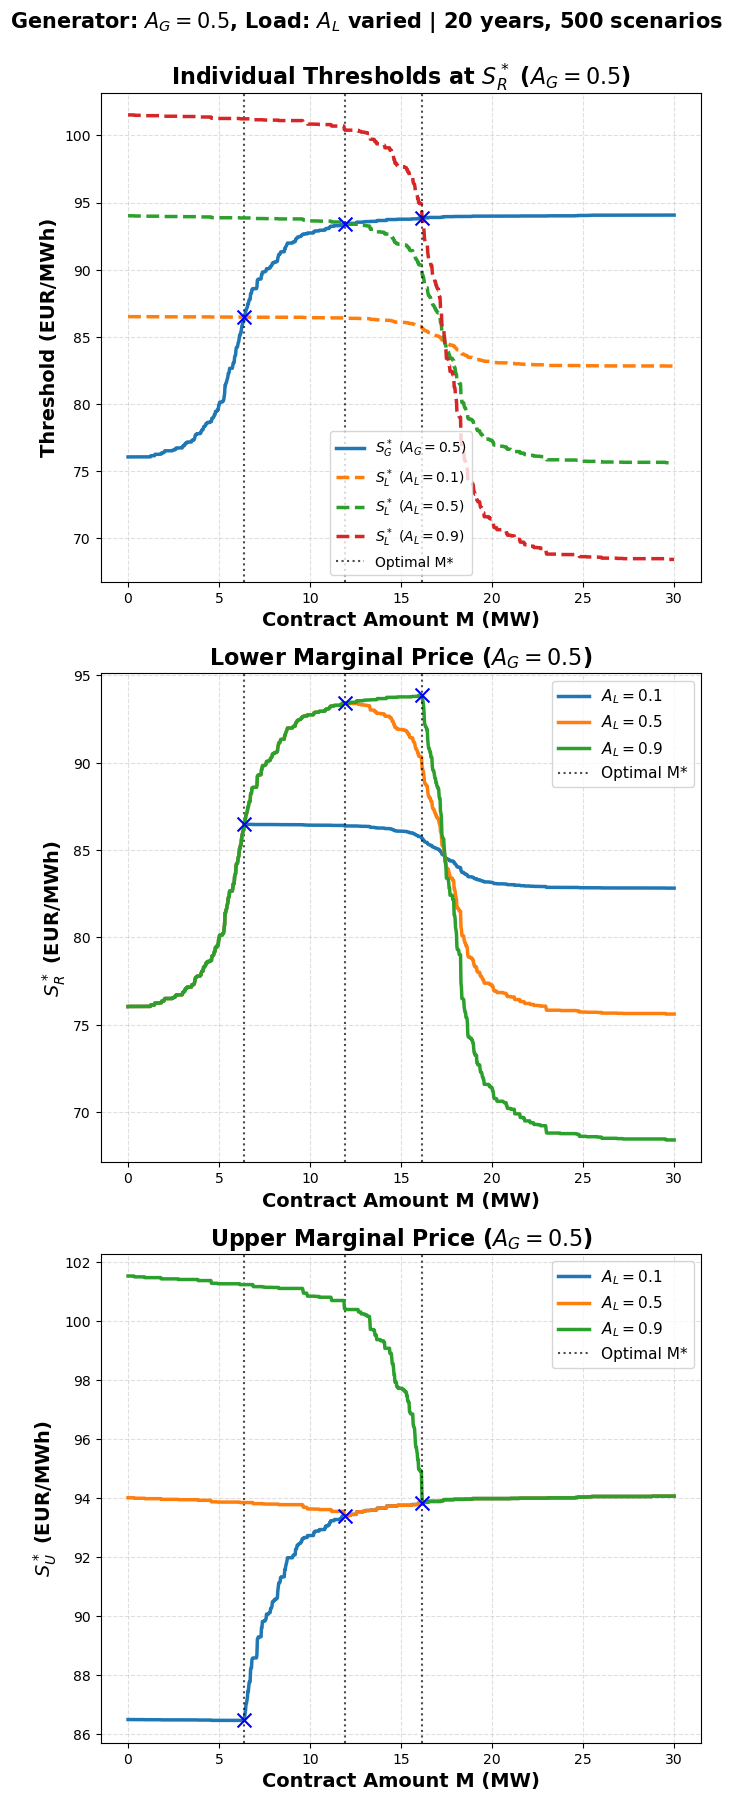

✓ Plots generated and saved



In [50]:

def calculate_initial_thresholds(
    production: np.ndarray,      # Shape (n_years, n_scenarios) - MWh per year
    capture_rate: np.ndarray,    # Shape (n_years, n_scenarios)
    prices: np.ndarray,          # Shape (n_years, n_scenarios) - EUR/MWh
    consumption: np.ndarray,    # Shape (n_years, n_scenarios) - MWh per year
    load_CR: np.ndarray,       # Shape (n_years, n_scenarios)
    probabilities: np.ndarray,   # Shape (n_scenarios,)
    A_G: float,
    A_L: float,
    alpha: float = 0.95,
    discount_factors_G: np.ndarray = None,  # Shape (n_years, 1)
    discount_factors_L: np.ndarray = None   # Shape (n_years, 1)
) -> dict:
    """
    Calculate S_R^* and S_U^* at M=0 (initial thresholds).
    
    These represent the feasible strike price range at the no-contract baseline.
    
    DATA STRUCTURE: (years, scenarios)
    - Each row = one year
    - Each column = one scenario
    
    Parameters:
    -----------
    production : np.ndarray
        Shape (n_years, n_scenarios) - production levels (MWh per year)
    capture_rate : np.ndarray
        Shape (n_years, n_scenarios) - capture rates
    prices : np.ndarray
        Shape (n_years, n_scenarios) - spot prices (EUR/MWh)
    probabilities : np.ndarray
        Shape (n_scenarios,) - scenario probabilities
    A_G : float
        Generator's risk aversion [0, 1]
    A_L : float
        Load's risk aversion [0, 1]
    alpha : float
        CVaR confidence level (default 0.95)
    discount_factors : np.ndarray, optional
        Shape (n_years, 1) - discount factors
    
    Returns:
    --------
    dict with keys:
        'S_G_star': Generator's threshold (EUR/MWh per year)
        'S_L_star': Load's threshold
        'SR_star': min(S_G_star, S_L_star)
        'SU_star': max(S_G_star, S_L_star)
        'mean_price': Mean spot price
        'tail_price_G': Average price in generator's tail
        'tail_price_L': Average price in load's tail
        'feasible': Boolean - whether bargaining range exists
    """
    
    n_years, n_scenarios = production.shape
    
    # Normalize probabilities
    probabilities = probabilities / probabilities.sum()
    
    # ========================================
    # GENERATOR CALCULATIONS
    # ========================================
    

    # Apply discounting if provided
    if discount_factors_G is not None:
        discounted_prices_G = prices * discount_factors_G
        lambda_sum_G = discounted_prices_G.sum(axis=0)
        T_effective_G = discount_factors_G.sum()
    else:
        lambda_sum_G = prices.sum(axis=0)
        T_effective_G = n_years

    if discount_factors_L is not None:
        discounted_prices_L = prices * discount_factors_L
        lambda_sum_L = discounted_prices_L.sum(axis=0)
        T_effective_L = discount_factors_L.sum()
    else:
        lambda_sum_L = prices.sum(axis=0)
        T_effective_L = n_years
        # At M=0, earnings are just spot revenue (no contract)
    
    
    total_production_CR = production * capture_rate  # (n_years, n_scenarios)
    spot_revenue_G = (total_production_CR * prices * discount_factors_G).sum(axis=0)  # Sum over years → (n_scenarios,)
    
    # Expected value
    expected_lambda_G = (probabilities * lambda_sum_G).sum()
    expected_lambda_L = (probabilities * lambda_sum_L).sum()



    
    # LEFT TAIL: worst earnings for generator
    ord_G, bidx_G = _left_tail_mask(spot_revenue_G, probabilities, alpha)
    
    # Conditional expectation in tail
    tail_lambda_G = _left_tail_weighted_sum(
        probabilities, lambda_sum_G, ord_G, bidx_G, alpha
    )
    
    # Calculate S^* for generator (per year)
    S_G_star = ((1 - A_G) * expected_lambda_G + A_G * tail_lambda_G) / T_effective_G
    
    # ========================================
    # LOAD CALCULATIONS
    # ========================================
    total_consumption_LR = consumption * load_CR  # (n_years, n_scenarios)
    spot_revenue_L = -(total_consumption_LR * prices * discount_factors_L).sum(axis=0)  # Sum over years → (n_scenarios,)
    
    # Load's LEFT TAIL: high price scenarios
    ord_L, bidx_L = _left_tail_mask(spot_revenue_L, probabilities, alpha)
    
    # Conditional expectation in high-price tail
    tail_lambda_L = _left_tail_weighted_sum(
        probabilities, lambda_sum_L, ord_L, bidx_L, alpha
    )
    
    # Calculate S^* for load (per year)
    S_L_star = ((1 - A_L) * expected_lambda_L + A_L * tail_lambda_L) / T_effective_L
    
    # ========================================
    # FINAL THRESHOLDS
    # ========================================
    
    SR_star = min(S_G_star, S_L_star)
    SU_star = max(S_G_star, S_L_star)
    
    return {
        'S_G_star': S_G_star*1e3,
        'S_L_star': S_L_star*1e3,
        'SR_star': SR_star*1e3,
        'SU_star': SU_star*1e3,
        'tail_price_G': tail_lambda_G / T_effective_G*1e3,
        'tail_price_L': tail_lambda_L / T_effective_L*1e3,
        'feasible': SR_star < SU_star
    }


def calculate_thresholds_at_M(
    M: float,                    # Annual contract amount (MWh/year)
    S_fixed: float,              # Strike price (EUR/MWh)
    production: np.ndarray,      # Shape (n_years, n_scenarios) - MWh per year
    capture_rate: np.ndarray,    # Shape (n_years, n_scenarios)
    prices: np.ndarray,          # Shape (n_years, n_scenarios) - EUR/MWh
    consumption: np.ndarray,    # Shape (n_years, n_scenarios) - MWh per year
    load_CR: np.ndarray,    # Shape (n_years, n_scenarios)
    probabilities: np.ndarray,   # Shape (n_scenarios,)
    A_G: float,
    A_L: float,
    alpha: float = 0.95,
    discount_factors_G: np.ndarray = None,  # Shape (n_years, 1)
    discount_factors_L: np.ndarray = None  # Shape (n_years, 1)
) -> dict:
    """
    Calculate S^* thresholds at a specific annual contract amount M.
    
    M represents MWh/year commitment (annual contract).
    
    Parameters:
    -----------
    M : float
        Annual contract amount (MWh/year)
    S_fixed : float
        Strike price (EUR/MWh)
    production : np.ndarray
        Shape (n_years, n_scenarios) - production levels (MWh per year)
    
    Returns:
    --------
    dict with keys:
        'S_G_star': Generator's threshold (EUR/MWh)
        'S_L_star': Load's threshold (EUR/MWh)
        'regime': str - 'uniformly_long', 'mixed', or 'uniformly_short'
        'min_production': Minimum annual production (MWh/year)
        'max_production': Maximum annual production (MWh/year)
    """
    
    n_years, n_scenarios = production.shape
    
    # Normalize probabilities    
    # ========================================
    # DETERMINE GENERATOR REGIME
    # ========================================
    
    total_production_CR = production * capture_rate   # (n_years, n_scenarios)
    
    # Min/max annual production across ALL scenario-years
    min_production = total_production_CR.min()  # MWh/year
    max_production = total_production_CR.max()  # MWh/year
    
    if M > max_production:
        regime = 'uniformly_short'
    elif M <= min_production:
        regime = 'uniformly_long'
    else:
        regime = 'mixed'
    
    # ========================================
    # GENERATOR CALCULATIONS AT (M, S_fixed)
    # ========================================
    
    # Calculate earnings at this (M, S_fixed)

    # Apply discounting if provided
    if discount_factors_G is not None:
        discounted_prices_G = prices * discount_factors_G
        lambda_sum_G = discounted_prices_G.sum(axis=0)
        T_effective_G = discount_factors_G.sum()
    else:
        lambda_sum_G = prices.sum(axis=0)
        T_effective_G = n_years

    if discount_factors_L is not None:
        discounted_prices_L = prices * discount_factors_L
        lambda_sum_L = discounted_prices_L.sum(axis=0)
        T_effective_L = discount_factors_L.sum()
    else:
        lambda_sum_L = prices.sum(axis=0)
        T_effective_L = n_years
    
    # Expected value
    expected_lambda_G = (probabilities * lambda_sum_G).sum()
    expected_lambda_L = (probabilities * lambda_sum_L).sum()
    

    spot_revenue_G = (total_production_CR * prices * discount_factors_G).sum(axis=0)  # Sum over years → (n_scenarios,)
    contract_payoff_G = ((S_fixed - prices) * M * discount_factors_G).sum(axis=0)    # Sum over years → (n_scenarios,)
    earnings_G = spot_revenue_G + contract_payoff_G
    

    # LEFT TAIL: worst earnings at this (M, S)
    ord_G, bidx_G = _left_tail_mask(earnings_G, probabilities, alpha)
    


    # Conditional expectation in tail
    tail_lambda_G = _left_tail_weighted_sum(
        probabilities, lambda_sum_G, ord_G, bidx_G, alpha
    )
    
    # Calculate S^* for generator at this M
    S_G_star = ((1 - A_G) * expected_lambda_G + A_G * tail_lambda_G) / T_effective_G 
    
    # ========================================
    # LOAD CALCULATIONS AT (M, S_fixed)
    # ========================================
    
    # Load earnings at (M, S_fixed)
    total_consumption_CR = consumption * load_CR  # (n_years, n_scenarios)
    spot_revenue_L = -(total_consumption_CR * prices * discount_factors_L).sum(axis=0)  # Sum over years → (n_scenarios,)
    contract_payoff_L = ((prices - S_fixed) * M * discount_factors_L).sum(axis=0)    # Sum over years → (n_scenarios,)
    earnings_L = spot_revenue_L + contract_payoff_L
    
    # LEFT TAIL for load
    ord_L, bidx_L = _left_tail_mask(earnings_L, probabilities, alpha)
    
    # Conditional expectation in tail
    tail_lambda_L = _left_tail_weighted_sum(
        probabilities, lambda_sum_L, ord_L, bidx_L, alpha
    )
    
    # Calculate S^* for load at this M
    S_L_star = ((1 - A_L) * expected_lambda_L + A_L * tail_lambda_L) / T_effective_L
    

    SR_star = min(S_G_star, S_L_star)
    SU_star = max(S_G_star, S_L_star)

    return {
        'S_G_star': S_G_star*1e3,
        'S_L_star': S_L_star*1e3,
        'SR_star': SR_star*1e3,
        'SU_star': SU_star*1e3,
        'regime': regime,
        'tail_price_G': tail_lambda_G / T_effective_G*1e3,
        'tail_price_L': tail_lambda_L / T_effective_L*1e3,
        'feasible': SR_star < SU_star

    }
# ============================================================================
# PART 1: INITIAL THRESHOLDS AT M=0
# ============================================================================

print("\n" + "="*80)
print("PART 1: INITIAL THRESHOLDS AT M=0")
print("="*80 + "\n")

# Define risk aversion ranges
risk_aversion_G = [0.1, 0.5, 0.9]
risk_aversion_L = np.linspace(0.0, 1.0, 100)

# Initialize arrays to store results
n_test = len(risk_aversion_L)
SR_array = np.empty((len(risk_aversion_G), n_test))
SU_array = np.empty((len(risk_aversion_G), n_test))
S_G_array = np.empty((len(risk_aversion_G), n_test))
S_L_array = np.empty((len(risk_aversion_G), n_test))
feasible_array = np.empty((len(risk_aversion_G), n_test), dtype=bool)



print("Computing initial thresholds for different risk aversion combinations...")
print(f"Generator risk aversions: {risk_aversion_G}")
print(f"Load risk aversions: {len(risk_aversion_L)} values from 0.0 to 1.0")
print(f"Data shape: prod={prod.shape}, prices={prices.shape}, CR={CR.shape}\n")

for i, A_G_loop in enumerate(risk_aversion_G):
    print(f"  A_G = {A_G:.1f}...", end=" ")
    for j, A_L_loop in enumerate(risk_aversion_L):
        
        # Calculate initial thresholds
        thresholds = calculate_initial_thresholds(
            production=prod,
            capture_rate=CR,
            prices=prices,
            consumption=load,
            load_CR=LR,
            probabilities=PROB,
            A_G=A_G_loop,
            A_L=A_L_loop,
            alpha=alpha,
            discount_factors_G=discount_factors_G,
            discount_factors_L=discount_factors_L
        )
        
        # Store results (data already in EUR/MWh)
        SR_array[i, j] = thresholds['SR_star']
        SU_array[i, j] = thresholds['SU_star']
        S_G_array[i, j] = thresholds['S_G_star']
        S_L_array[i, j] = thresholds['S_L_star']
        feasible_array[i, j] = thresholds['feasible']
    
    print(f"✓ Complete")

print(f"\n✓ Initial threshold calculations complete!")

# ============================================================================
# PART 2: DYNAMIC THRESHOLDS AS FUNCTION OF M
# ============================================================================

print("\n" + "="*80)
print("PART 2: DYNAMIC THRESHOLDS PER M")
print("="*80 + "\n")

# Choose specific risk aversion values for M-sweep
A_G_fixed = A_G
# Test multiple A_L values
A_L_values = [
    0.1, 0.5, 0.9]  # Three different load risk aversions

print(f"Computing thresholds for A_G={A_G_fixed}, A_L varied...")

# Get initial thresholds for the fixed A_G and middle A_L
initial = calculate_initial_thresholds(
    production=prod,
    capture_rate=CR,
    prices=prices,
    consumption=load,
    load_CR=LR,
    probabilities=PROB,
    A_G=A_G_fixed,
    A_L=0.5,  # Use middle value for initial threshold
    alpha=alpha,
    discount_factors_G=discount_factors_G,
    discount_factors_L=discount_factors_L
)

S_fixed_low = 40*1e-3  # EUR/MWh
S_fixed_high = 120*1e-3  # EUR/MWh

print(f"  Initial SR* (low):  {S_fixed_low:.2f} EUR/MWh")
print(f"  Initial SU* (high): {S_fixed_high:.2f} EUR/MWh")
print(f"  Initial S_G*:       {initial['S_G_star']:.2f} EUR/MWh")
print(f"  Initial S_L*:       {initial['S_L_star']:.2f} EUR/MWh\n")

# Define M range based on annual production
total_production_CR = (prod / 8760 * 1e3) * CR  # (n_years, n_scenarios)
min_avg_annual_prod = total_production_CR.min()
max_avg_annual_prod = total_production_CR.max()

total_consumption_LR = (load / 8760 * 1e3) * LR
min_avg_annual_cons = total_consumption_LR.min()
max_avg_annual_cons = total_consumption_LR.max()

M_arr = np.linspace(0, 30 * 8760 * 1e-3, 1200)  # MWh/year

print(f"Annual production range: [{min_avg_annual_prod:.2f}, {max_avg_annual_prod:.2f}] MWh/year")
print(f"Annual consumption range: [{min_avg_annual_cons:.2f}, {max_avg_annual_cons:.2f}] MWh/year")
print(f"Contract amount range: [0, {M_arr.max():.2f}] MWh/year\n")

# Arrays to store results - now indexed by A_L variation
SR_vs_M = np.empty((len(A_L_values), len(M_arr)))
SU_vs_M = np.empty((len(A_L_values), len(M_arr)))
S_G_Star_vs_M_SR = np.empty((len(A_L_values), len(M_arr)))
S_L_Star_vs_M_SR = np.empty((len(A_L_values), len(M_arr)))
S_G_Star_vs_M_SU = np.empty((len(A_L_values), len(M_arr)))
S_L_Star_vs_M_SU = np.empty((len(A_L_values), len(M_arr)))

print("Computing thresholds for each M value and A_L combination...")

M_opt = np.empty((len(risk_aversion_G)))
S_opt = np.empty((len(risk_aversion_G)))

for i, A_L_loop in enumerate(A_L_values):  # ← FIXED: Now correctly iterating over A_L
    print(f"  A_L = {A_L:.1f}...", end=" ")
    
    for k, M_value in enumerate(M_arr):  # ← FIXED: Renamed to M_value to avoid shadowing
        
        # At low strike price (SR*)
        result_low = calculate_thresholds_at_M(
            M=M_value,  # ← FIXED: Use M_value
            S_fixed=S_fixed_low,
            production=prod,
            capture_rate=CR,
            prices=prices,
            consumption=load,
            load_CR=LR,
            probabilities=PROB,
            A_G=A_G,
            A_L=A_L_loop,  # ← FIXED: Use the loop variable A_L
            alpha=alpha,
            discount_factors_G=discount_factors_G,
            discount_factors_L=discount_factors_L
        )
        
        SR_vs_M[i, k] = result_low['SR_star']
        S_G_Star_vs_M_SR[i, k] = result_low['S_G_star']
        S_L_Star_vs_M_SR[i, k] = result_low['S_L_star']
        
        # At high strike price (SU*)
        result_high = calculate_thresholds_at_M(
            M=M_value,  # ← FIXED: Use M_value
            S_fixed=S_fixed_high,
            production=prod,
            capture_rate=CR,
            prices=prices,
            consumption=load,
            load_CR=LR,
            probabilities=PROB,
            A_G=A_G,
            A_L=A_L_loop,  # ← FIXED: Use the loop variable A_L
            alpha=alpha,
            discount_factors_G=discount_factors_G,
            discount_factors_L=discount_factors_L
        )
        
        SU_vs_M[i, k] = result_high['SU_star']
        S_G_Star_vs_M_SU[i, k] = result_high['S_G_star']
        S_L_Star_vs_M_SU[i, k] = result_high['S_L_star']
    
    print(f"✓ Complete")
    # Initialize contract data
    contract_data = ContractData(
    scenario_path=scenario_path,
    time_horizon=time_horizon,
    num_scenarios=num_scenarios,
    discount_rate_G=discount_rate_G,
    discount_rate_L=discount_rate_L,
    alpha=0.95,
    strikeprice_min=40 * 1e-3,
    strikeprice_max=130 * 1e-3,  # EUR/MWh
    contract_amount_min=0,
    contract_amount_max= generator_contract_capacity * 8760 * 1e-3 ,  # GWh/year
    A_G=A_G,  # Generator's risk aversion
    A_L=A_L_loop,  # Load's risk aversion
    tau_G=tau_G,  # Generator's bargaining power
    tau_L=tau_L,   # Load's bargaining power
    Scenarios_S= Scenarios_S,
    Scenarios_M= Scenarios_M,
)
    # Initialize and run Nash Bargaining model
    model_marginal = NashBargaining(contract_data)
    model_marginal.run()
    M_opt[i] = model_marginal.results.avg_contract_amount_hour
    S_opt[i] = model_marginal.results.avg_strike_price

print(f"\n✓ Dynamic threshold calculations complete!")

# ============================================================================
# VISUALIZATION: CORRECTED PLOTS
# ============================================================================

print("\n" + "="*80)
print("GENERATING PLOTS")
print("="*80 + "\n")

fig, axes = plt.subplots(3, figsize=(7, 18))

# Common styling
x_ticks = np.linspace(0, M_arr.max() / 8760 * 1e3, 7)
grid_style = dict(alpha=0.4, linestyle='--')

# Plot 1: S_G* and S_L* at SR* (lower threshold)
ax = axes[0]

ax.plot(M_arr / 8760 * 1e3, S_G_Star_vs_M_SR[1, :], 
            label=f'$S_G^*$ ($A_G={A_G_fixed:.1f}$)', linewidth=2.5, linestyle='-')
for i, A_L_loop in enumerate(A_L_values):
    
    ax.plot(M_arr / 8760 * 1e3, S_L_Star_vs_M_SU[i, :], 
            label=f'$S_L^*$ ($A_L={A_L_loop:.1f}$)', linewidth=2.5, linestyle='--')
    # Find the closest M value for S_G_Star_vs_M_SR and S_L_Star_vs_M_SU to M_opt[i]
    closest_idx_SG = np.argmin(np.abs(S_G_Star_vs_M_SR[i, :] - S_L_Star_vs_M_SR[i]))
    closest_idx_SL = np.argmin(np.abs(S_L_Star_vs_M_SU[i, :] - S_G_Star_vs_M_SR[i]))
    
    # Scatter the optimal points
    ax.scatter(M_arr[closest_idx_SG] / 8760 * 1e3, S_G_Star_vs_M_SR[i, closest_idx_SG], 
               color='blue', s=100, zorder=5, marker='x')
    if i == len(A_L_values)-1:  # Only label once for clarity
        ax.axvline(M_opt[i], color='black', linestyle=':', 
            linewidth=1.5, alpha=0.7,label='Optimal M*')
    else:
        ax.axvline(M_opt[i], color='black', linestyle=':', 
            linewidth=1.5, alpha=0.7)
        
ax.set_xlabel('Contract Amount M (MW)', fontsize=14, fontweight='bold')
ax.set_ylabel('Threshold (EUR/MWh)', fontsize=14, fontweight='bold')
ax.set_title(f'Individual Thresholds at $S_R^*$ ($A_G={A_G_fixed}$)', 
             fontsize=16, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.set_xticks(x_ticks)
ax.grid(**grid_style)


# Plot 3: SR* vs M
ax = axes[1]
for i, A_L_loop in enumerate(A_L_values):
    ax.plot(M_arr / 8760 * 1e3, SR_vs_M[i, :], 
            label=f'$A_L={A_L_loop:.1f}$', linewidth=2.5)

    closest_idx_SG = np.argmin(np.abs(S_G_Star_vs_M_SR[i, :] - S_L_Star_vs_M_SR[i]))
    closest_idx_SL = np.argmin(np.abs(S_L_Star_vs_M_SU[i, :] - S_G_Star_vs_M_SR[i]))
    
    # Scatter the optimal points
    ax.scatter(M_arr[closest_idx_SG] / 8760 * 1e3, S_G_Star_vs_M_SR[i, closest_idx_SG], 
               color='blue', s=100, zorder=5, marker='x')

    if i == len(A_L_values)-1:  # Only label once for clarity
        ax.axvline(M_opt[i], color='black', linestyle=':', 
            linewidth=1.5, alpha=0.7,label='Optimal M*')
    else:
        ax.axvline(M_opt[i], color='black', linestyle=':', 
            linewidth=1.5, alpha=0.7)



ax.set_xlabel('Contract Amount M (MW)', fontsize=14, fontweight='bold')
ax.set_ylabel('$S_R^*$ (EUR/MWh)', fontsize=14, fontweight='bold')
ax.set_title(f'Lower Marginal Price ($A_G={A_G_fixed}$)', 
             fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.set_xticks(x_ticks)
ax.grid(**grid_style)

# Plot 4: SU* vs M
ax = axes[2]
for i, A_L_loop in enumerate(A_L_values):
    ax.plot(M_arr / 8760 * 1e3, SU_vs_M[i, :], 
            label=f'$A_L={A_L_loop:.1f}$', linewidth=2.5)
    closest_idx_SG = np.argmin(np.abs(S_G_Star_vs_M_SR[i, :] - S_L_Star_vs_M_SR[i]))
    closest_idx_SL = np.argmin(np.abs(S_L_Star_vs_M_SU[i, :] - S_G_Star_vs_M_SR[i]))
    
    # Scatter the optimal points
    ax.scatter(M_arr[closest_idx_SG] / 8760 * 1e3, S_G_Star_vs_M_SR[i, closest_idx_SG], 
               color='blue', s=100, zorder=5, marker='x')

    if i == len(A_L_values)-1:  # Only label once for clarity
        ax.axvline(M_opt[i], color='black', linestyle=':', 
            linewidth=1.5, alpha=0.7,label='Optimal M*')
    else:
        ax.axvline(M_opt[i], color='black', linestyle=':', 
            linewidth=1.5, alpha=0.7)
           

ax.set_xlabel('Contract Amount M (MW)', fontsize=14, fontweight='bold')
ax.set_ylabel('$S_U^*$ (EUR/MWh)', fontsize=14, fontweight='bold')
ax.set_title(f'Upper Marginal Price ($A_G={A_G_fixed}$)', 
             fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.set_xticks(x_ticks)
ax.grid(**grid_style)

plt.suptitle(f'Generator: $A_G={A_G_fixed}$, Load: $A_L$ varied | 20 years, 500 scenarios', 
             fontsize=15, fontweight='bold', y=0.998)
plt.tight_layout()
plt.savefig('threshold_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plots generated and saved\n")

In [51]:
# Your model parameters
model_A_G = A_G
model_A_L = A_L

# Find which A_L index in your sweep matches the model
A_L_values = [0.1, 0.5, 0.9]
A_L_idx = A_L_values.index(model_A_L)  # Should be 0

# Get SR* at the correct (M*, A_L) combination
M_target = model.results.avg_contract_amount_hour
M_values = M_arr / 8760 * 1e3
closest_idx = np.argmin(np.abs(M_values - M_target))

SR_at_M_star_correct = SR_vs_M[A_L_idx, closest_idx]
SU_at_M_star_correct = SU_vs_M[A_L_idx, closest_idx]

print("\n" + "="*70)
print("CORRECT THRESHOLD COMPARISON")
print(M_values[closest_idx], M_target)
print("="*70)
print(f"Model parameters:")
print(f"  $A_G$ = {model_A_G}, $A_L$ = {model_A_L}")
print(f'  $tau_G$ = {contract_data.tau_G}, $tau_L$ = {contract_data.tau_L}')
print(f"  M* = {M_target:.2f} MWh")
print(f"  S* = {model.results.avg_strike_price:.2f} EUR/MWh")
print(f"\nThresholds at M=0:")
print(f"  SR*(M=0) = {contract_data.SR_star_new * 1e3:.2f} EUR/MWh")
print(f"  SU*(M=0) = {contract_data.SU_star_new * 1e3:.2f} EUR/MWh")
print(f"\nThresholds at M={M_target:.2f} MWh:")
print(f"  SR*(M*) = {SR_at_M_star_correct:.2f} EUR/MWh")
print(f"  SU*(M*) = {SU_at_M_star_correct:.2f} EUR/MWh")
print(f"\nFeasibility check:")
print(f"  SR*(M*) ≤ S* ≤ SU*(M*)?")
print(f"  {SR_at_M_star_correct:.2f} ≤ {model.results.avg_strike_price:.2f} ≤ {SU_at_M_star_correct:.2f}")
if SR_at_M_star_correct <= model.results.avg_strike_price <= SU_at_M_star_correct:
    print("  ✓ FEASIBLE - S* is within thresholds!")
else:
    print("  ✗ INFEASIBLE - S* violates thresholds!")
print("="*70)


CORRECT THRESHOLD COMPARISON
11.909924937447874 11.921044867510739
Model parameters:
  $A_G$ = 0.5, $A_L$ = 0.5
  $tau_G$ = 0.5, $tau_L$ = 0.5
  M* = 11.92 MWh
  S* = 89.12 EUR/MWh

Thresholds at M=0:
  SR*(M=0) = 76.05 EUR/MWh
  SU*(M=0) = 101.53 EUR/MWh

Thresholds at M=11.92 MWh:
  SR*(M*) = 93.40 EUR/MWh
  SU*(M*) = 93.41 EUR/MWh

Feasibility check:
  SR*(M*) ≤ S* ≤ SU*(M*)?
  93.40 ≤ 89.12 ≤ 93.41
  ✗ INFEASIBLE - S* violates thresholds!


dCVaR/dM = 1.3629
Initial Threshold at M=0 SR* [EUR/MWh]: 76.046
Initial Threshold at M=0 SU* [EUR/MWh]: 94.016
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06
Set parameter FeasibilityTol to value 1e-06

-------------------   RESULTS GUROBI  -------------------
Optimal Objective Value (Log): 0.54804
Avg Strike Price (EUR/MWh): 85.02636
Lower Strike Price SR* (EUR/MWh): 0.07605
Upper Strike Price SU* (EUR/MWh): 0.09402
Avg Contract Amount (GWh/year): 9.63600
Avg Contract Amount (MWh): 1.10000
Avg Earnings G: 95.55342
Avg Earnings L: -254.14215
CVaR G: 77.37426
CVaR L: -307.92049
Utility G: 86.46384
Utility L: -281.03132
Threat Point G: 84.73399
Threat Point L: -282.76117
Nash Product: 2.99239
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06

-------------------   RESULTS GUROBI  -------------------
Optimal Objective Value (Log): 0.54804
Avg Strike Price (EUR/MWh): 85.02636
Lower Strike Price SR* (EUR/MWh): 0.07605
Upper Strik

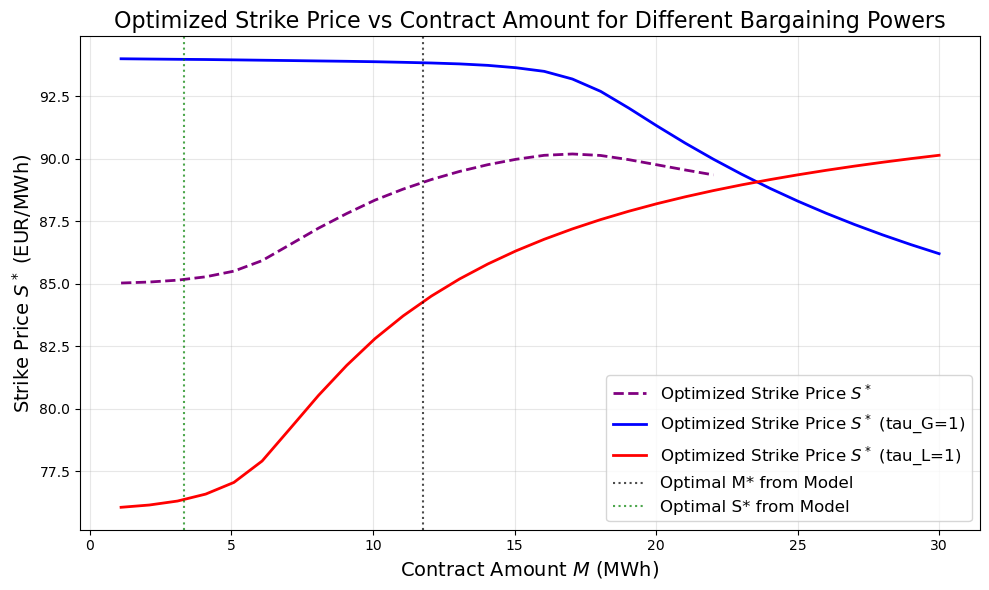

In [ ]:
# Initialize arrays to store the optimized strike prices
optimized_strike_prices = []
optimized_strike_prices_tauG = []
optimized_strike_prices_tauL = []

# Initialize arrays to store the feasible contract amounts
feasible_M = []
feasible_M_tauG = []
feasible_M_tauL = []

# Example usage
scenario_path = "scenarios"
time_horizon = 20
num_scenarios = 500
generator_contract_capacity = 30  # MW
Scenarios_S = False
Scenarios_M = False
discount_rate_G = 0.0
discount_rate_L = 0.0
A_G = 0.5
A_L = 0.5
tau_G = 0.5
tau_L = 1-tau_G


# Initialize contract data
contract_data_new = ContractData(
    scenario_path=scenario_path,
    time_horizon=time_horizon,
    num_scenarios=num_scenarios,
    discount_rate_G=discount_rate_G,
    discount_rate_L=discount_rate_L,
    alpha=0.95,
    strikeprice_min=40 * 1e-3,
    strikeprice_max=130 * 1e-3,  # EUR/MWh
    contract_amount_min=0,
    contract_amount_max= generator_contract_capacity * 8760 * 1e-3 ,  # GWh/year
    A_G=A_G,  # Generator's risk aversion
    A_L=A_L,  # Load's risk aversion
    tau_G=tau_G,  # Generator's bargaining power
    tau_L=tau_L,   # Load's bargaining power
    Scenarios_S= Scenarios_S,
    Scenarios_M= Scenarios_M,
)
# Initialize and run Nash Bargaining model
contract_data_copy = copy.deepcopy(contract_data_new)  
contract_data_opt = copy.deepcopy(contract_data_copy)


M_arr = np.linspace(1.1 * 8760 * 1e-3, 30 * 8760 * 1e-3, 30)  # MWh/year

# Loop through M_arr and optimize for S* with the fixed contract amount
for M in M_arr:
    try:
        model = NashBargaining(contract_data_opt, fixed_contract_amount=M)
        model.run()
        optimized_strike_prices.append(model.results.avg_strike_price)
        feasible_M.append(M)
    except RuntimeError:
        print(f"Model infeasible for M={M:.2f}. Breaking loop.")
        break

# Run for tau_G = 1
contract_data_tauG = copy.deepcopy(contract_data_copy)
contract_data_tauG.tau_G = 1
contract_data_tauG.tau_L = 0

for M in M_arr:
    try:
        model_tauG = NashBargaining(contract_data_tauG, fixed_contract_amount=M)
        model_tauG.run()
        optimized_strike_prices_tauG.append(model_tauG.results.avg_strike_price)
        feasible_M_tauG.append(M)
    except RuntimeError:
        print(f"Model infeasible for tau_G=1, M={M:.2f}. Breaking loop.")
        break

# Run for tau_L = 1
contract_data_tauL = copy.deepcopy(contract_data_copy)
contract_data_tauL.tau_G = 0
contract_data_tauL.tau_L = 1

for M in M_arr:
    try:
        model_tauL = NashBargaining(contract_data_tauL, fixed_contract_amount=M)
        model_tauL.run()
        optimized_strike_prices_tauL.append(model_tauL.results.avg_strike_price)
        feasible_M_tauL.append(M)
    except RuntimeError:
        print(f"Model infeasible for tau_L=1, M={M:.2f}. Breaking loop.")
        break

# Convert the lists to numpy arrays for easier plotting
optimized_strike_prices = np.array(optimized_strike_prices)
optimized_strike_prices_tauG = np.array(optimized_strike_prices_tauG)
optimized_strike_prices_tauL = np.array(optimized_strike_prices_tauL)
feasible_M = np.array(feasible_M)
feasible_M_tauG = np.array(feasible_M_tauG)
feasible_M_tauL = np.array(feasible_M_tauL)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(feasible_M / 8760 * 1e3, optimized_strike_prices, label='Optimized Strike Price $S^*$', color='purple', linewidth=2, linestyle='--')
plt.plot(feasible_M_tauG / 8760 * 1e3, optimized_strike_prices_tauG, label='Optimized Strike Price $S^*$ (tau_G=1)', color='blue', linewidth=2)
plt.plot(feasible_M_tauL / 8760 * 1e3, optimized_strike_prices_tauL, label='Optimized Strike Price $S^*$ (tau_L=1)', color='red', linewidth=2)
plt.xlabel('Contract Amount $M$ (MWh)', fontsize=14)
plt.ylabel('Strike Price $S^*$ (EUR/MWh)', fontsize=14)
plt.title('Optimized Strike Price vs Contract Amount for Different Bargaining Powers', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [93]:
# Example usage
scenario_path = "scenarios"
time_horizon = 20
num_scenarios = 500
generator_contract_capacity = 30  # MW
Scenarios_S = False
Scenarios_M = False
discount_rate_G = 0.0
discount_rate_L = 0.0
A_G = 0.5
A_L = 0.5
tau_G = 0.5
tau_L = 1-tau_G


# Initialize contract data
contract_data = ContractData(
    scenario_path=scenario_path,
    time_horizon=time_horizon,
    num_scenarios=num_scenarios,
    discount_rate_G=discount_rate_G,
    discount_rate_L=discount_rate_L,
    alpha=0.95,
    strikeprice_min=40 * 1e-3,
    strikeprice_max=130 * 1e-3,  # EUR/MWh
    contract_amount_min=0,
    contract_amount_max= generator_contract_capacity * 8760 * 1e-3 ,  # GWh/year
    A_G=A_G,  # Generator's risk aversion
    A_L=A_L,  # Load's risk aversion
    tau_G=tau_G,  # Generator's bargaining power
    tau_L=tau_L,   # Load's bargaining power
    Scenarios_S= Scenarios_S,
    Scenarios_M= Scenarios_M,
)
# Initialize and run Nash Bargaining model
model = NashBargaining(contract_data)
contract_data_copy = copy.deepcopy(contract_data)
model.run()

dCVaR/dM = 1.3629
Initial Threshold at M=0 SR* [EUR/MWh]: 76.046
Initial Threshold at M=0 SU* [EUR/MWh]: 94.016
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06
Set parameter FeasibilityTol to value 1e-06

-------------------   RESULTS GUROBI  -------------------
Optimal Objective Value (Log): 2.28832
Avg Strike Price (EUR/MWh): 89.11818
Lower Strike Price SR* (EUR/MWh): 0.07605
Upper Strike Price SU* (EUR/MWh): 0.09402
Avg Contract Amount (GWh/year): 104.42835
Avg Contract Amount (MWh): 11.92104
Avg Earnings G: 104.86657
Avg Earnings L: -263.45530
CVaR G: 84.31816
CVaR L: -282.35030
Utility G: 94.59236
Utility L: -272.90280
Threat Point G: 84.73399
Threat Point L: -282.76117
Nash Product: 97.18758

-------------------   RESULTS GUROBI  -------------------
Optimal Objective Value (Log): 2.28832
Avg Strike Price (EUR/MWh): 89.11818
Lower Strike Price SR* (EUR/MWh): 0.07605
Upper Strike Price SU* (EUR/MWh): 0.09402
Avg Contract Amount (GWh/year): 104.42835
A

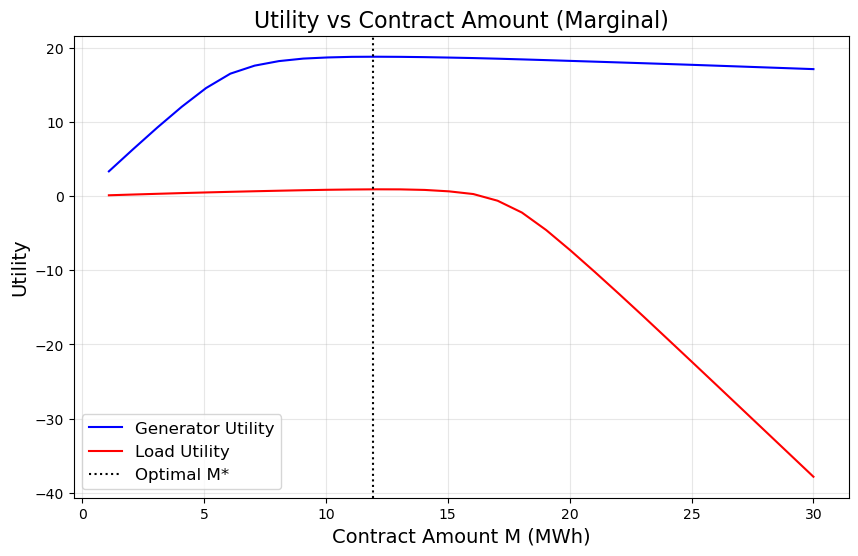

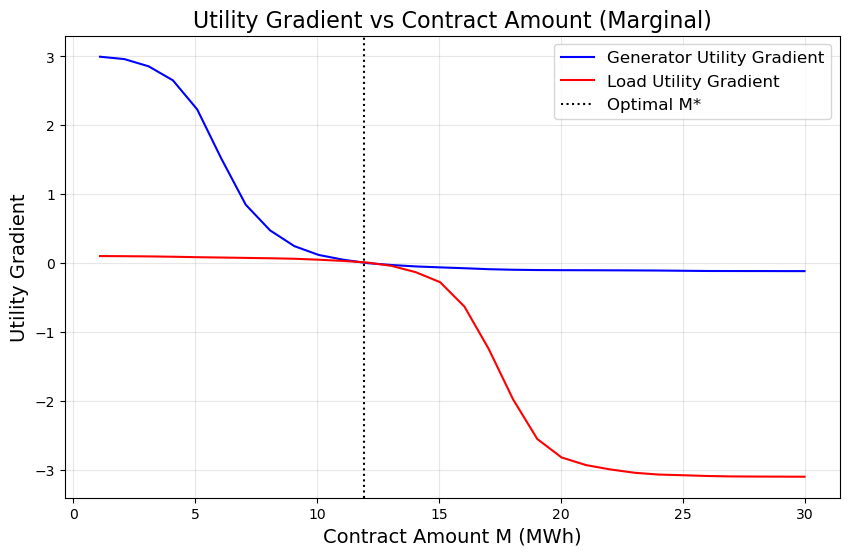

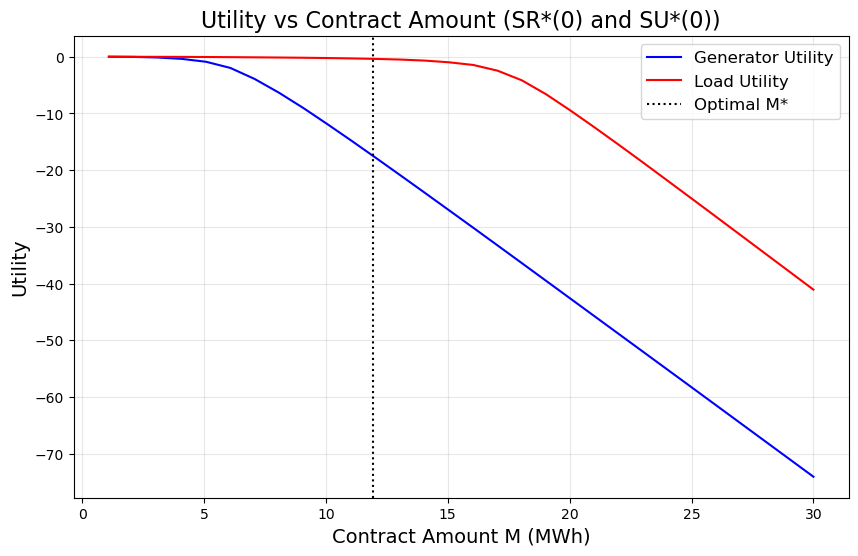

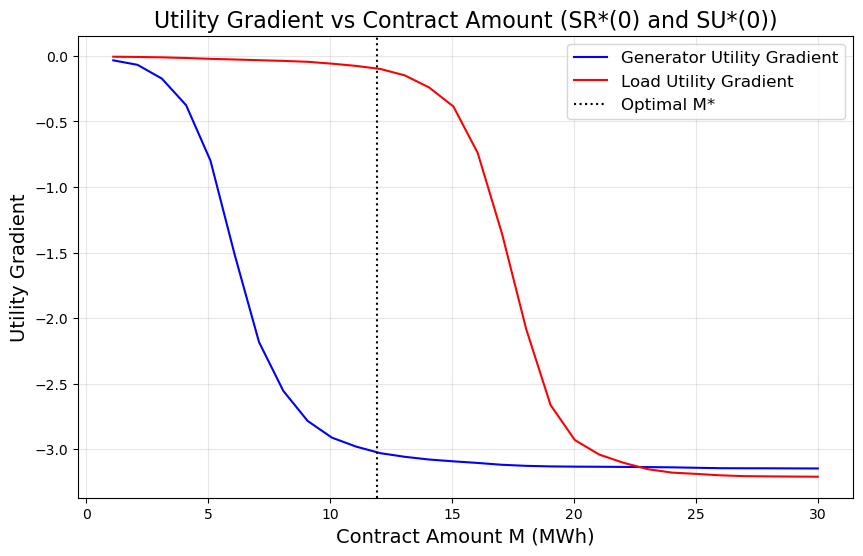

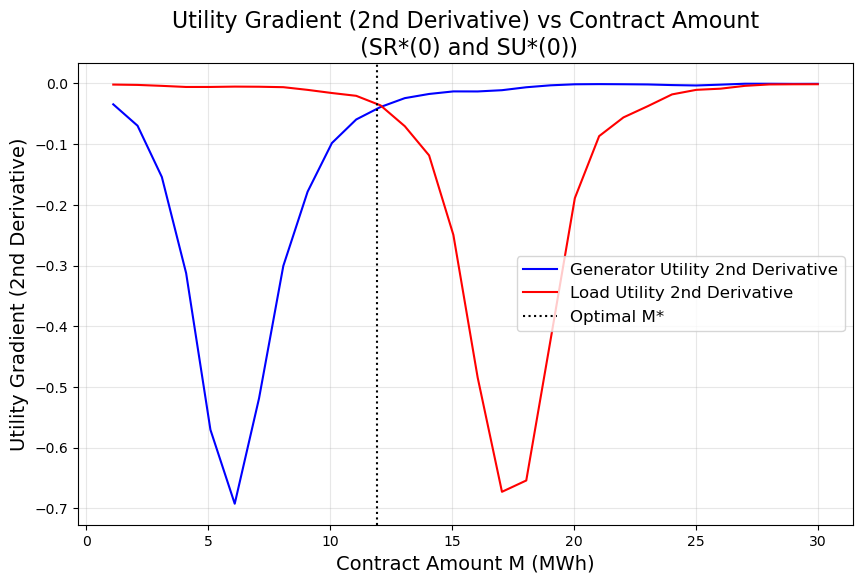

In [94]:
def calculate_utility(strike, volume, data, is_generator=True):
    """
    Calculate utility for generator or load given strike price and volume.
    
    Args:
        strike : Strike Price [float]
        volume : Contract volume [float] or percentage [float] in PAP
        data   : ContractData object with scenario arrays and parameters
        is_generator : Boolean, True for generator utility, False for load utility
    
    Returns:
        Utility value (float)
    """
    if is_generator:
        rev_contract = (data.discount_factors_G_arr * volume * (strike - data.price_G)).sum(axis=0)
        no_contract = data.net_earnings_no_contract_priceG_G
        risk_aversion = data.A_G
    else:
        rev_contract = (data.discount_factors_L_arr * volume * (data.price_L - strike)).sum(axis=0)
        no_contract = data.net_earnings_no_contract_priceL_L
        risk_aversion = data.A_L

    earnings = no_contract + rev_contract
    CVaR = calculate_cvar_left(earnings, data.PROB, data.alpha)
    utility = (1 - risk_aversion) * (data.PROB * earnings).sum() + risk_aversion * CVaR
    return utility


# Initialize utilities
gen_marginal_utility = []
load_marginal_utility = []
generator_utilities = []
load_utilities = []

# No-contract utilities
no_contract_G = model.data.Zeta_G
no_contract_L = model.data.Zeta_L

# Set risk aversion parameters
contract_data.A_G = 0.5
contract_data.A_L = 0.5

#Use SR*=SU* (marginal price)

strike_marginal = SR_at_M_star_correct

# Calculate utilities for SR and SU
for volume in zip(M_arr):
    gen_marginal_utility.append(calculate_utility(strike_marginal * 1e-3, volume, contract_data, is_generator=True))
    load_marginal_utility.append(calculate_utility((strike_marginal) * 1e-3, volume, contract_data, is_generator=False))
    generator_utilities.append(calculate_utility(model.data.SR_star_new, volume, contract_data, is_generator=True))
    load_utilities.append(calculate_utility(model.data.SU_star_new, volume, contract_data, is_generator=False))

# Convert to numpy arrays
gen_marginal_utility = np.array(gen_marginal_utility)
load_marginal_utility = np.array(load_marginal_utility)
generator_utilities = np.array(generator_utilities)
load_utilities = np.array(load_utilities)

# Calculate gradients
generator_utilities_gradient_SU = np.gradient(gen_marginal_utility)
load_utilities_gradient_SU = np.gradient(load_marginal_utility)
generator_utilities_gradient = np.gradient(generator_utilities)
load_utilities_gradient = np.gradient(load_utilities)
generator_utilities_gradient_gradient = np.gradient(generator_utilities_gradient)
load_utilities_gradient_gradient = np.gradient(load_utilities_gradient)

# Plot utilities
def plot_utility(x, y1, y2, xlabel, ylabel, title, legend1, legend2, optimal_x, filename=None):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y1, label=legend1, color='blue')
    plt.plot(x, y2, label=legend2, color='red')
    plt.axvline(optimal_x, color='black', linestyle=':', linewidth=1.5, label='Optimal M*')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Plot results
x_values = M_arr / 8760 * 1e3
optimal_M = model.results.avg_contract_amount_hour

plot_utility(
    x_values, gen_marginal_utility - no_contract_G, load_marginal_utility - no_contract_L,
    'Contract Amount M (MWh)', 'Utility', 'Utility vs Contract Amount (Marginal)',
    'Generator Utility', 'Load Utility', optimal_M
)

plot_utility(
    x_values, generator_utilities_gradient_SU, load_utilities_gradient_SU,
    'Contract Amount M (MWh)', 'Utility Gradient', 'Utility Gradient vs Contract Amount (Marginal)',
    'Generator Utility Gradient', 'Load Utility Gradient', optimal_M
)

plot_utility(
    x_values, generator_utilities - no_contract_G, load_utilities - no_contract_L,
    'Contract Amount M (MWh)', 'Utility', 'Utility vs Contract Amount (SR*(0) and SU*(0))',
    'Generator Utility', 'Load Utility', optimal_M
)

plot_utility(
    x_values, generator_utilities_gradient, load_utilities_gradient,
    'Contract Amount M (MWh)', 'Utility Gradient', 'Utility Gradient vs Contract Amount (SR*(0) and SU*(0))',
    'Generator Utility Gradient', 'Load Utility Gradient', optimal_M
)

plot_utility(
    x_values, generator_utilities_gradient_gradient, load_utilities_gradient_gradient,
    'Contract Amount M (MWh)', 'Utility Gradient (2nd Derivative)', 'Utility Gradient (2nd Derivative) vs Contract Amount\n (SR*(0) and SU*(0))' ,
    'Generator Utility 2nd Derivative', 'Load Utility 2nd Derivative', optimal_M
)

In [104]:
def find_strike_price_for_UG_zero(
    M: float,
    production: np.ndarray,
    capture_rate: np.ndarray,
    prices: np.ndarray,
    probabilities: np.ndarray,
    discount_factors_G: np.ndarray,
    A_G: float,
    alpha: float,
    zeta_G: float,
    S_min: float = 0.01,
    S_max: float = 0.20,
    S_prev: float = None,  # Previous strike price
    tolerance: float = 1e-4,
    max_iterations: int = 2000
) -> float:
    """
    Find the strike price S such that U_G - zeta_G = 0 for a given contract amount M.
    """
    # Compute the base spot revenue without a contract
    total_production_CR = production * capture_rate
    spot_revenue_base = (total_production_CR * prices * discount_factors_G).sum(axis=0)

    def compute_utility(S):
        """
        Compute U_G for a given strike price S.
        """
        # Contract payoff at (M, S)
        contract_payoff = ((S - prices) * M * discount_factors_G).sum(axis=0)

        # Total earnings at (M, S)
        earnings_G = spot_revenue_base + contract_payoff

        # Compute CVaR of earnings
        CVaR_G = calculate_cvar_left(earnings_G, probabilities, alpha)

        # Compute utility with numerical stability
        expected_earnings = (probabilities * earnings_G).sum()
        
        # Handle extreme risk aversion cases
        if A_G < 1e-10:  # Risk-neutral
            return expected_earnings
        elif A_G > (1 - 1e-10):  # Extremely risk-averse
            return CVaR_G
        else:
            return (1 - A_G) * expected_earnings + A_G * CVaR_G

    # Initialize S
    if S_prev is not None:
        S = np.clip(S_prev / 1e3, S_min, S_max)  # Use previous value as starting point
    else:
        S = (S_min + S_max) / 2  # Midpoint if no previous value

    iteration = 0
    while iteration < max_iterations:
        U_G = compute_utility(S)
        utility_diff = U_G - zeta_G

        # Check if the utility difference is within the tolerance
        if abs(utility_diff) < tolerance:
            return S * 1e3  # Convert to EUR/MWh

        # Adjust S based on the utility difference
        if utility_diff > 0:
            S_max = S
        else:
            S_min = S

        S = (S_min + S_max) / 2  # Update S to the midpoint
        iteration += 1

    print(f"Warning: Maximum iterations reached for U_G. Returning S={S:.5f}")
    return S * 1e3  # Convert to EUR/MWh


def find_strike_price_for_UL_zero(
    M: float,
    consumption: np.ndarray,
    load_CR: np.ndarray,
    prices: np.ndarray,
    probabilities: np.ndarray,
    discount_factors_L: np.ndarray,
    A_L: float,
    alpha: float,
    zeta_L: float,
    S_min: float = 0.01,
    S_max: float = 0.20,
    S_prev: float = None,  # Previous strike price
    tolerance: float = 1e-4,
    max_iterations: int = 2000
) -> float:
    """
    Find the strike price S such that U_L - zeta_L = 0 for a given contract amount M.
    """
    # Compute the base spot cost without a contract
    total_consumption_LR = consumption * load_CR
    spot_cost_base = -(total_consumption_LR * prices * discount_factors_L).sum(axis=0)

    def compute_utility(S):
        """
        Compute U_L for a given strike price S.
        """
        # Contract payoff at (M, S)
        contract_payoff = ((prices - S) * M * discount_factors_L).sum(axis=0)

        # Total earnings at (M, S)
        earnings_L = spot_cost_base + contract_payoff

        # Compute CVaR of earnings
        CVaR_L = calculate_cvar_left(earnings_L, probabilities, alpha)

        # Compute utility with numerical stability
        expected_earnings = (probabilities * earnings_L).sum()
        
        # Handle extreme risk aversion cases
        if A_L < 1e-10:  # Risk-neutral
            return expected_earnings
        elif A_L > (1 - 1e-10):  # Extremely risk-averse
            return CVaR_L
        else:
            return (1 - A_L) * expected_earnings + A_L * CVaR_L

    # Initialize S
    if S_prev is not None:
        S = np.clip(S_prev / 1e3, S_min, S_max)  # Use previous value as starting point
    else:
        S = (S_min + S_max) / 2  # Midpoint if no previous value

    iteration = 0
    while iteration < max_iterations:
        U_L = compute_utility(S)
        utility_diff = U_L - zeta_L

        # Check if the utility difference is within the tolerance
        if abs(utility_diff) < tolerance:
            return S * 1e3  # Convert to EUR/MWh

        # Adjust S based on the utility difference
        if utility_diff > 0:
            S_min = S
        else:
            S_max = S

        S = (S_min + S_max) / 2  # Update S to the midpoint
        iteration += 1

    print(f"Warning: Maximum iterations reached for U_L. Returning S={S:.5f}")
    return S * 1e3  # Convert to EUR/MWh

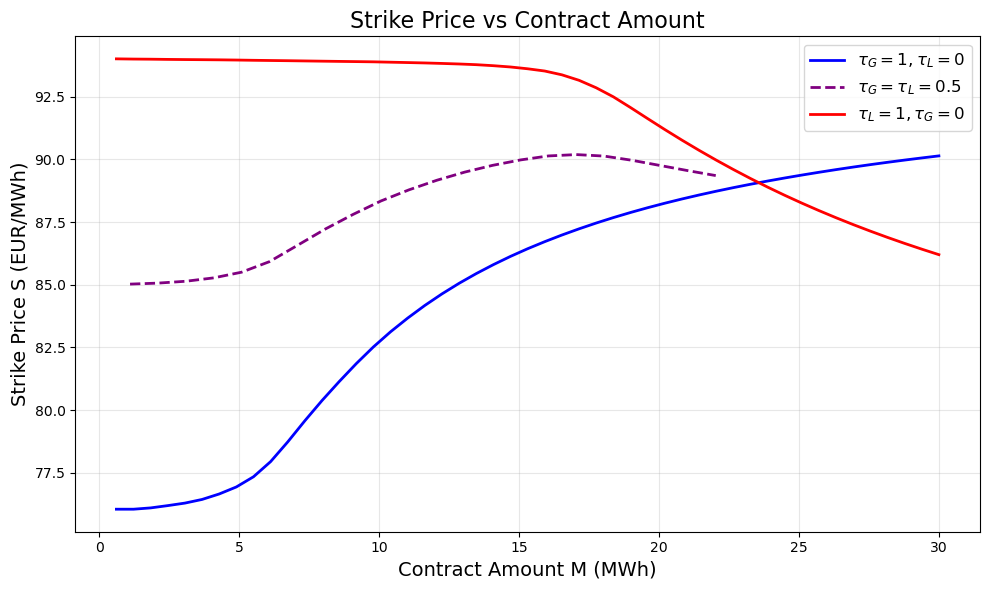

In [105]:
# Initialize an array to store the strike prices
strike_prices_gen = []
strike_prices_load = []
A_G = 0.5
A_L = 0.5

M_arr = np.linspace(0, 30 * 8760 *1e-3, 50)  # Contract amounts from 0 to 15,000 MWh
S_prev_gen = None
S_prev_load = None

# Loop through M_arr and calculate the strike price for each M
for M in M_arr[1:]:
    S_gen = find_strike_price_for_UG_zero(M, prod, CR, prices, PROB, discount_factors_G, A_G, alpha, model.data.Zeta_G, S_prev=S_prev_gen)
    S_load = find_strike_price_for_UL_zero(M, load, LR, prices, PROB, discount_factors_L, A_L, alpha, model.data.Zeta_L, S_prev=S_prev_load)
    
    strike_prices_gen.append(S_gen)
    strike_prices_load.append(S_load)

# Convert the list to a numpy array for easier plotting
strike_prices_gen = np.array(strike_prices_gen)
strike_prices_load = np.array(strike_prices_load)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(M_arr[1:] / 8760 * 1e3, strike_prices_gen, label='$\\tau_G=1, \\tau_L=0$', color='blue', linewidth=2)
plt.plot(feasible_M / 8760 * 1e3, optimized_strike_prices, label='$\\tau_G = \\tau_L = 0.5$', color='purple', linewidth=2, linestyle='--')
plt.plot(M_arr[1:] / 8760 * 1e3, strike_prices_load, label='$\\tau_L=1, \\tau_G=0$', color='red', linewidth=2)
plt.xlabel('Contract Amount M (MWh)', fontsize=14)
plt.ylabel('Strike Price S (EUR/MWh)', fontsize=14)
plt.title('Strike Price vs Contract Amount', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [111]:
# Initialize arrays to store the optimized strike prices for each A_L and tau configuration
optimized_strike_prices_all = []
optimized_strike_prices_tauG_all = []
optimized_strike_prices_tauL_all = []
feasible_M_all = []
feasible_M_tauG_all = []
feasible_M_tauL_all = []

# Fixed A_G
A_G = 0.5

# Values of A_L to iterate over
A_L_values = [0.1, 0.5, 0.9]

# Contract amounts
M_arr = np.linspace(1.1 * 8760 * 1e-3, 30 * 8760 * 1e-3, 30)  # MWh/year

# Loop through each A_L value
for A_L in A_L_values:
    optimized_strike_prices = []
    optimized_strike_prices_tauG = []
    optimized_strike_prices_tauL = []
    feasible_M = []
    feasible_M_tauG = []
    feasible_M_tauL = []

    # Initialize contract data for the current A_L
    contract_data_new = ContractData(
        scenario_path=scenario_path,
        time_horizon=time_horizon,
        num_scenarios=num_scenarios,
        discount_rate_G=discount_rate_G,
        discount_rate_L=discount_rate_L,
        alpha=0.95,
        strikeprice_min=40 * 1e-3,
        strikeprice_max=130 * 1e-3,  # EUR/MWh
        contract_amount_min=0,
        contract_amount_max=generator_contract_capacity * 8760 * 1e-3,  # GWh/year
        A_G=A_G,  # Generator's risk aversion
        A_L=A_L,  # Load's risk aversion
        tau_G=tau_G,  # Generator's bargaining power
        tau_L=tau_L,  # Load's bargaining power
        Scenarios_S=Scenarios_S,
        Scenarios_M=Scenarios_M,
    )
    contract_data_opt = copy.deepcopy(contract_data_new)

    # Loop through M_arr and optimize for S* with the fixed contract amount
    for M in M_arr:
        try:
            # Run for tau_G = tau_L = 0.5
            model = NashBargaining(contract_data_opt, fixed_contract_amount=M)
            model.run()
            optimized_strike_prices.append(model.results.avg_strike_price)
            feasible_M.append(M)
        except RuntimeError:
            print(f"Model infeasible for A_L={A_L}, M={M:.2f}. Breaking loop.")
            break

    # Run for tau_G = 1
    contract_data_tauG = copy.deepcopy(contract_data_new)
    contract_data_tauG.tau_G = 1
    contract_data_tauG.tau_L = 0

    for M in M_arr:
        try:
            model_tauG = NashBargaining(contract_data_tauG, fixed_contract_amount=M)
            model_tauG.run()
            optimized_strike_prices_tauG.append(model_tauG.results.avg_strike_price)
            feasible_M_tauG.append(M)
        except RuntimeError:
            print(f"Model infeasible for tau_G=1, A_L={A_L}, M={M:.2f}. Breaking loop.")
            break

    # Run for tau_L = 1
    contract_data_tauL = copy.deepcopy(contract_data_new)
    contract_data_tauL.tau_G = 0
    contract_data_tauL.tau_L = 1

    for M in M_arr:
        try:
            model_tauL = NashBargaining(contract_data_tauL, fixed_contract_amount=M)
            model_tauL.run()
            optimized_strike_prices_tauL.append(model_tauL.results.avg_strike_price)
            feasible_M_tauL.append(M)
        except RuntimeError:
            print(f"Model infeasible for tau_L=1, A_L={A_L}, M={M:.2f}. Breaking loop.")
            break

    # Store results for this A_L
    optimized_strike_prices_all.append(np.array(optimized_strike_prices))
    optimized_strike_prices_tauG_all.append(np.array(optimized_strike_prices_tauG))
    optimized_strike_prices_tauL_all.append(np.array(optimized_strike_prices_tauL))
    feasible_M_all.append(np.array(feasible_M))
    feasible_M_tauG_all.append(np.array(feasible_M_tauG))
    feasible_M_tauL_all.append(np.array(feasible_M_tauL))

# Plot the results


dCVaR/dM = 1.3629
Initial Threshold at M=0 SR* [EUR/MWh]: 76.046
Initial Threshold at M=0 SU* [EUR/MWh]: 86.501
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06
Set parameter FeasibilityTol to value 1e-06

-------------------   RESULTS GUROBI  -------------------
Optimal Objective Value (Log): 0.00670
Avg Strike Price (EUR/MWh): 81.27424
Lower Strike Price SR* (EUR/MWh): 0.07605
Upper Strike Price SU* (EUR/MWh): 0.08650
Avg Contract Amount (GWh/year): 9.63600
Avg Contract Amount (MWh): 1.10000
Avg Earnings G: 94.83032
Avg Earnings L: -253.41904
CVaR G: 76.65115
CVaR L: -307.19738
Utility G: 85.74073
Utility L: -258.79688
Threat Point G: 84.73399
Threat Point L: -259.80357
Nash Product: 1.01349
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06

-------------------   RESULTS GUROBI  -------------------
Optimal Objective Value (Log): 0.00670
Avg Strike Price (EUR/MWh): 81.27424
Lower Strike Price SR* (EUR/MWh): 0.07605
Upper Strik

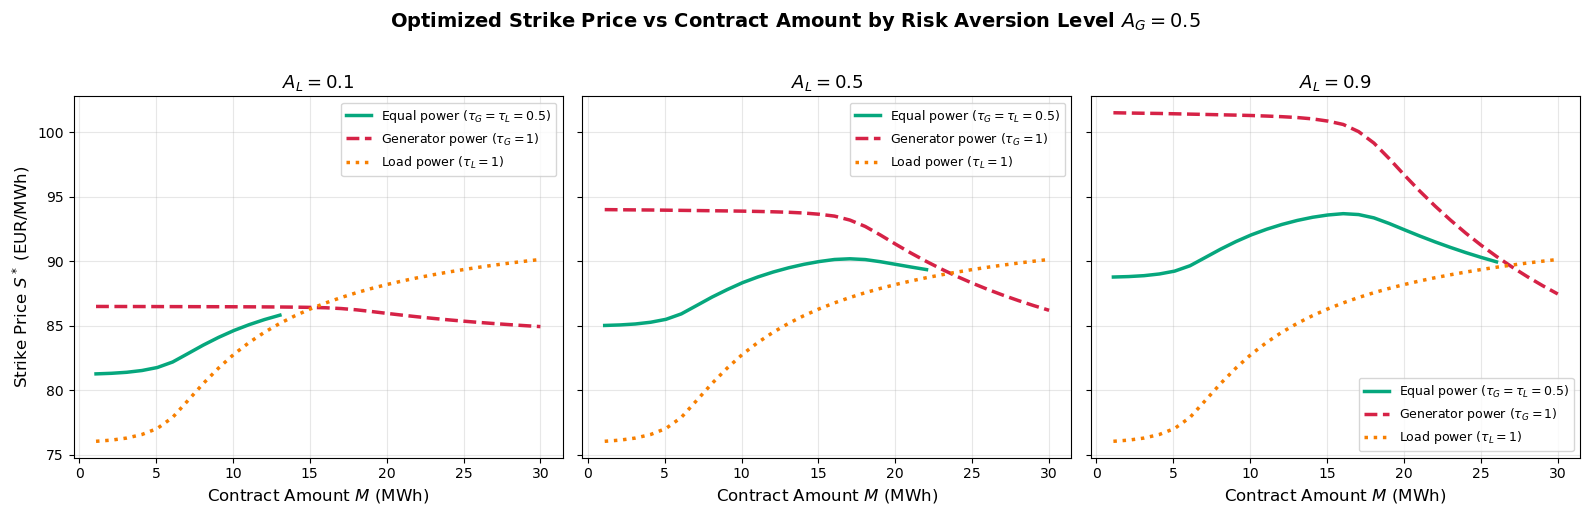

In [115]:
import matplotlib.pyplot as plt
import numpy as np

# Define color palettes
bargaining_colors = {'equal': '#06A77D', 'generator': '#D62246', 'load': '#F77F00'}

# ============================================
# Version 1: Grouped by Risk Aversion (A_L)
# ============================================
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for idx, A_L in enumerate(A_L_values):
    ax = axes[idx]
    
    # Plot three bargaining power scenarios
    ax.plot(feasible_M_all[idx] / 8760 * 1e3, optimized_strike_prices_all[idx],
            color=bargaining_colors['equal'], linewidth=2.5, linestyle='-',
            label='Equal power ($\\tau_G=\\tau_L=0.5$)')
    
    ax.plot(feasible_M_tauG_all[idx] / 8760 * 1e3, optimized_strike_prices_tauG_all[idx],
            color=bargaining_colors['generator'], linewidth=2.5, linestyle='--',
            label='Generator power ($\\tau_G=1$)')
    
    ax.plot(feasible_M_tauL_all[idx] / 8760 * 1e3, optimized_strike_prices_tauL_all[idx],
            color=bargaining_colors['load'], linewidth=2.5, linestyle=':',
            label='Load power ($\\tau_L=1$)')
    
    ax.set_xlabel('Contract Amount $M$ (MWh)', fontsize=12)
    ax.set_title(f'$A_L = {A_L}$', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(fontsize=9, loc='best')

axes[0].set_ylabel('Strike Price $S^*$ (EUR/MWh)', fontsize=12)
fig.suptitle('Optimized Strike Price vs Contract Amount by Risk Aversion Level $A_G=0.5$', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


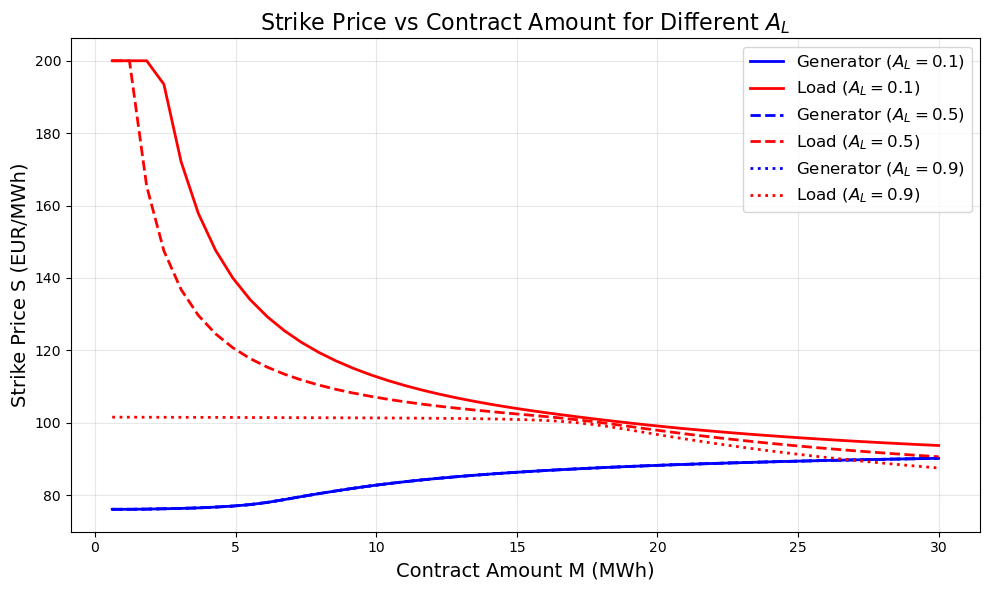

In [113]:
# Initialize arrays to store the strike prices for each A_L
strike_prices_gen_all = []
strike_prices_load_all = []

# Fixed A_G
A_G = 0.5

# Values of A_L to iterate over
A_L_values = [0.1, 0.5, 0.9]

# Contract amounts
M_arr = np.linspace(0, 30 * 8760 * 1e-3, 50)  # Contract amounts from 0 to 15,000 MWh

# Loop through each A_L value
for A_L in A_L_values:
    strike_prices_gen = []
    strike_prices_load = []
    S_prev_gen = None
    S_prev_load = None

    # Loop through M_arr and calculate the strike price for each M
    for M in M_arr[1:]:
        S_gen = find_strike_price_for_UG_zero(
            M, prod, CR, prices, PROB, discount_factors_G, A_G, alpha, model.data.Zeta_G, S_prev=S_prev_gen
        )
        S_load = find_strike_price_for_UL_zero(
            M, load, LR, prices, PROB, discount_factors_L, A_L, alpha, model.data.Zeta_L, S_prev=S_prev_load
        )

        strike_prices_gen.append(S_gen)
        strike_prices_load.append(S_load)

        # Update previous strike prices
        S_prev_gen = S_gen
        S_prev_load = S_load

    # Store results for this A_L
    strike_prices_gen_all.append(np.array(strike_prices_gen))
    strike_prices_load_all.append(np.array(strike_prices_load))

# Plot the results
plt.figure(figsize=(10, 6))

# Plot for each A_L
for i, A_L in enumerate(A_L_values):
    plt.plot(
        M_arr[1:] / 8760 * 1e3, strike_prices_gen_all[i],
        label=f'Generator ($A_L={A_L}$)', color='blue', linewidth=2, linestyle=['-', '--', ':'][i]
    )
    plt.plot(
        M_arr[1:] / 8760 * 1e3, strike_prices_load_all[i],
        label=f'Load ($A_L={A_L}$)', color='red', linewidth=2, linestyle=['-', '--', ':'][i]
    )

# Add labels and legend
plt.xlabel('Contract Amount M (MWh)', fontsize=14)
plt.ylabel('Strike Price S (EUR/MWh)', fontsize=14)
plt.title('Strike Price vs Contract Amount for Different $A_L$', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()